In [1]:
import numpy as np 
import pandas as pd
import iqcell
import os
import logging
import traceback

HI
iqcell successfully imported


In [2]:
os.chdir("../")
main_path = os.getcwd()

In [3]:
main_output_path = os.path.join(main_path, "output", "iQcell_simulations")
main_input_path = os.path.join("../../../../Beeline_benchmark/run_iQcell")

In [6]:
data_types = os.listdir("Beeline_benchmark/run_iQcell/")
data_types = [x for x in data_types if os.path.isdir(os.path.join("Beeline_benchmark/run_iQcell/", x))]
data_types = [x for x in data_types if x != '.ipynb_checkpoints']

In [7]:
data_types

['dyn-LL',
 'mCAD',
 'HSC',
 'dyn-LI',
 'dyn-BFC',
 'dyn-CY',
 'dyn-TF',
 'GSD',
 'VSC',
 'dyn-BF']

Mean method threshlding


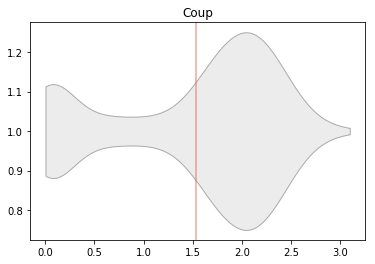

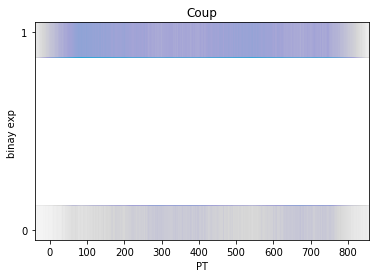

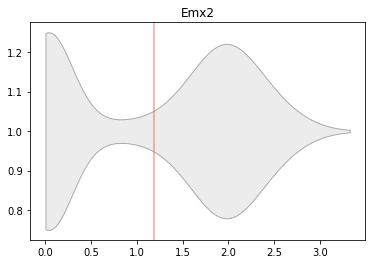

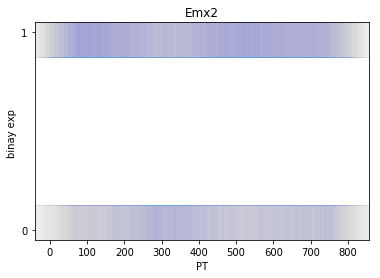

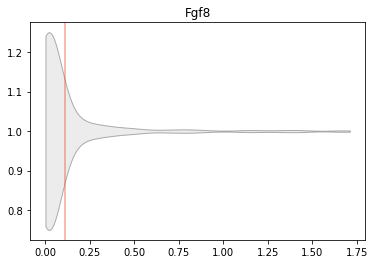

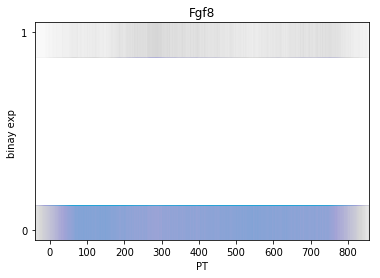

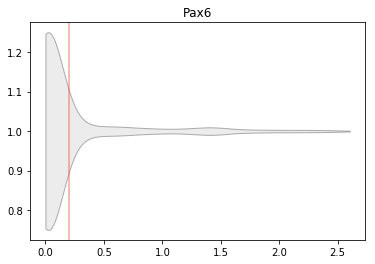

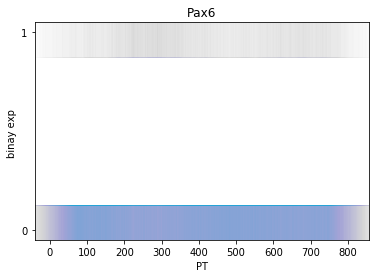

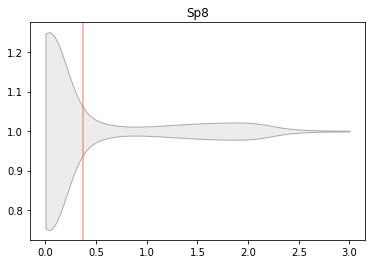

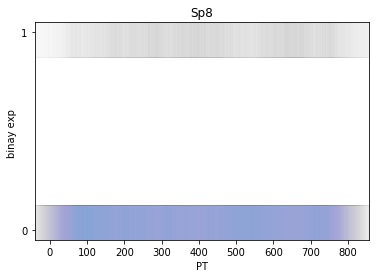

K-mean method threshlding


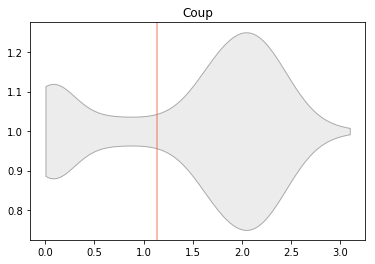

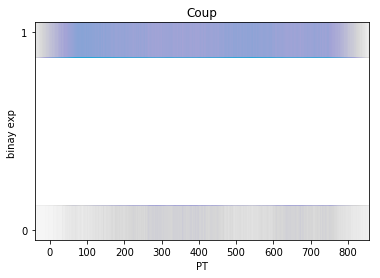

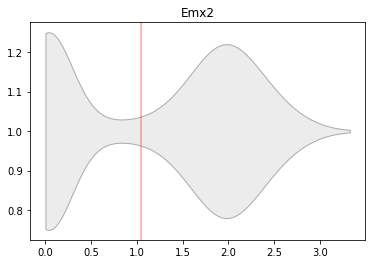

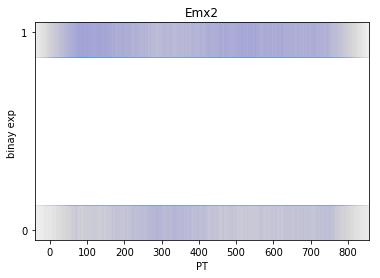

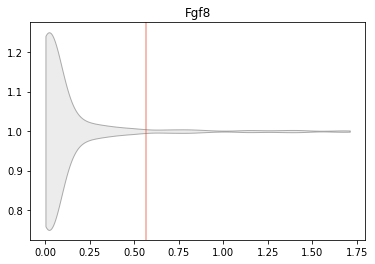

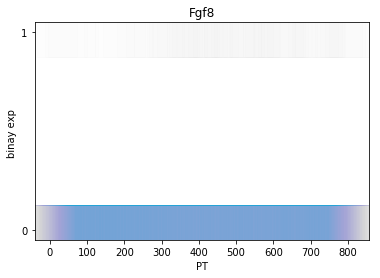

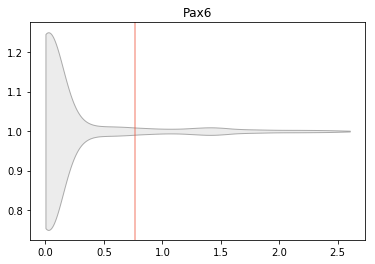

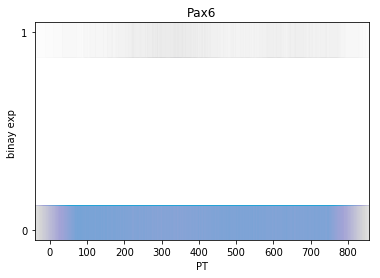

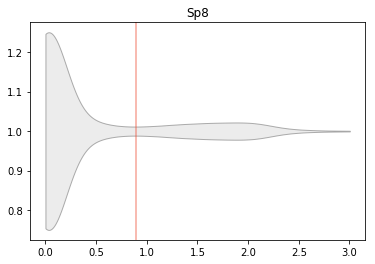

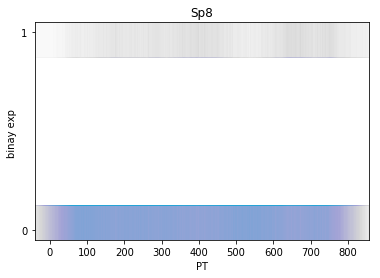

Mean method threshlding


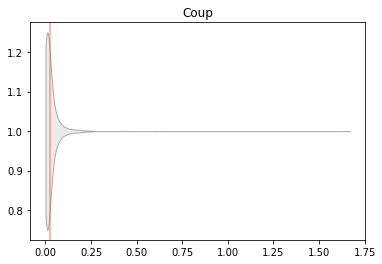

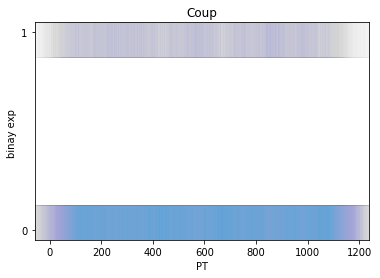

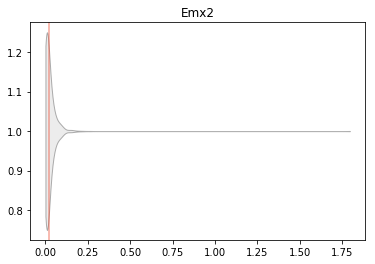

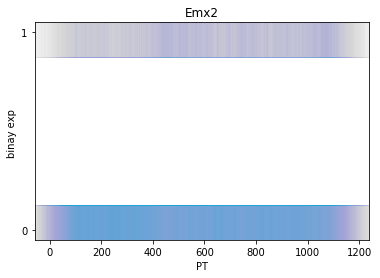

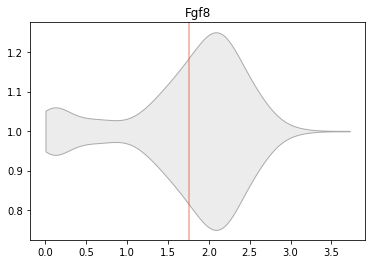

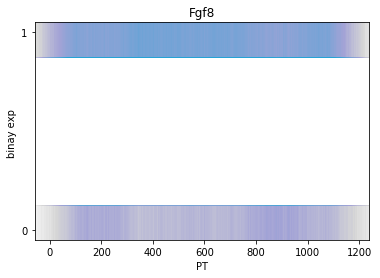

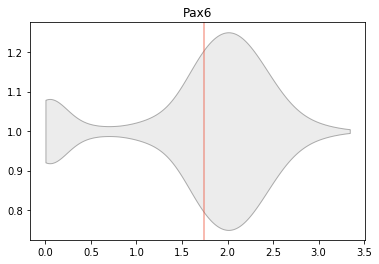

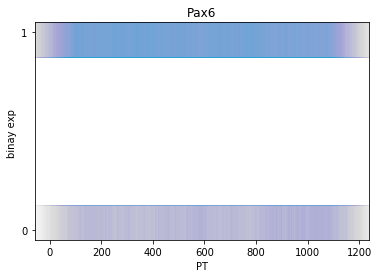

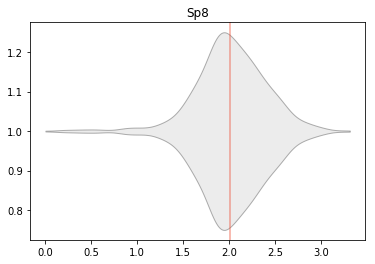

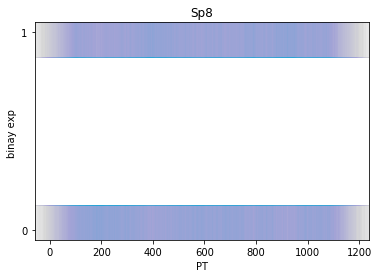

K-mean method threshlding


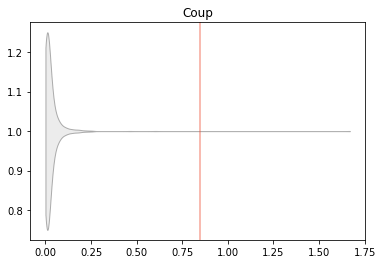

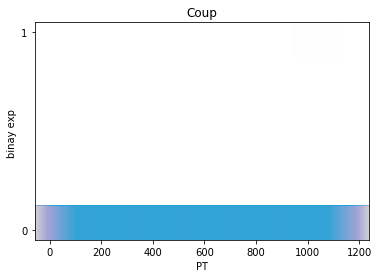

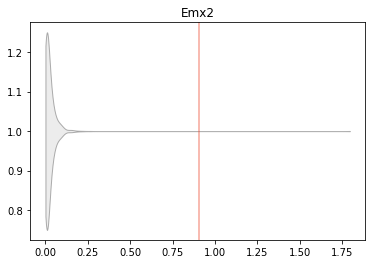

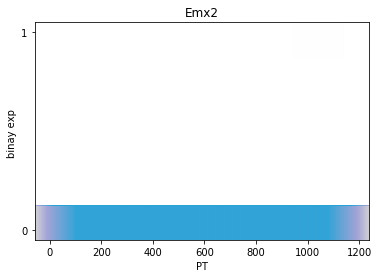

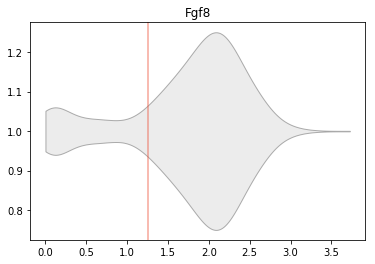

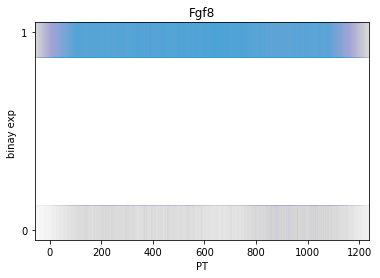

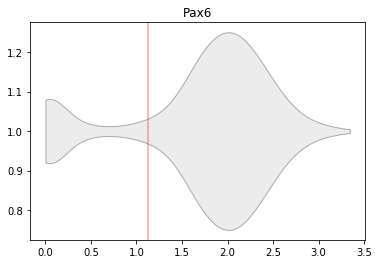

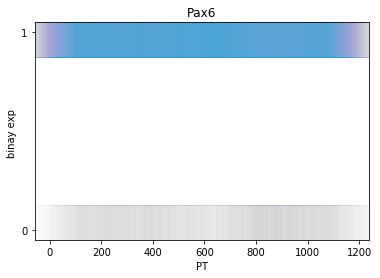

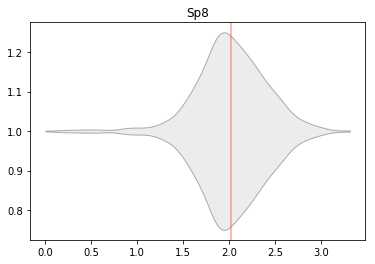

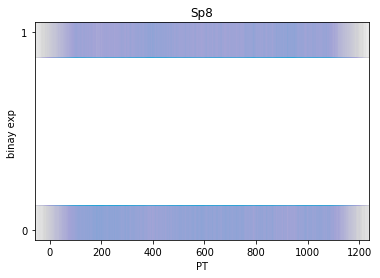

Mean method threshlding


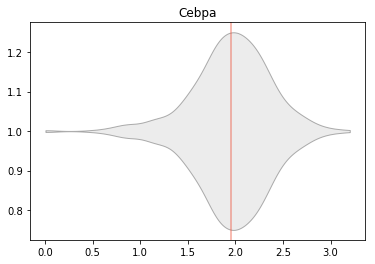

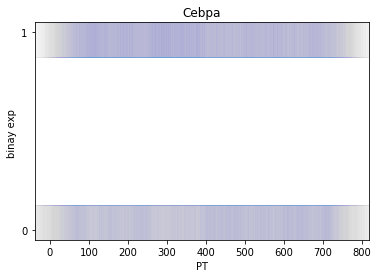

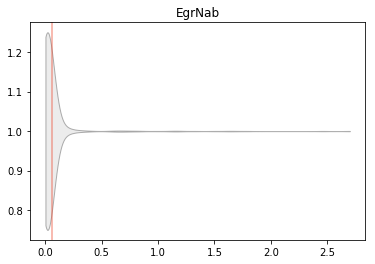

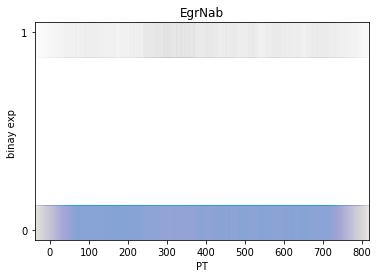

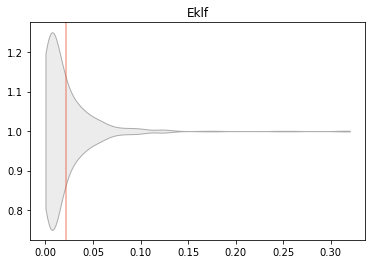

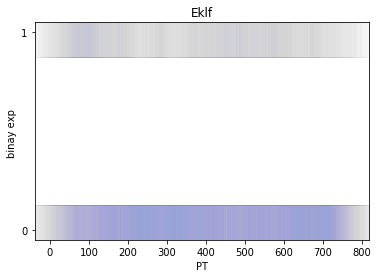

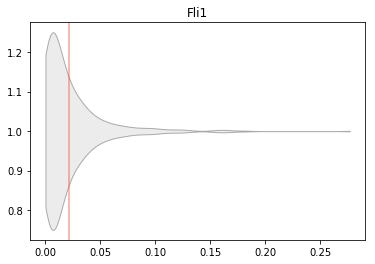

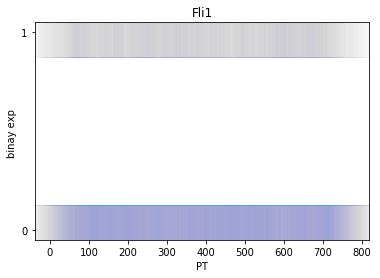

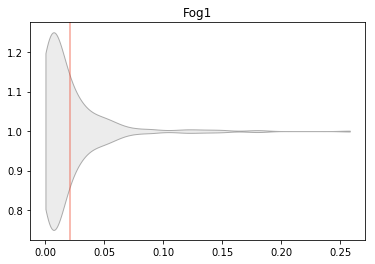

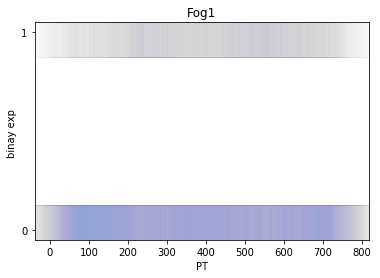

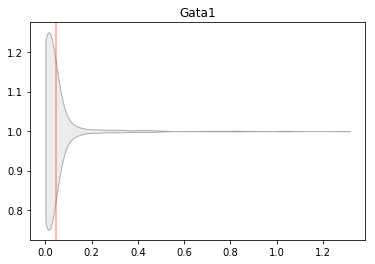

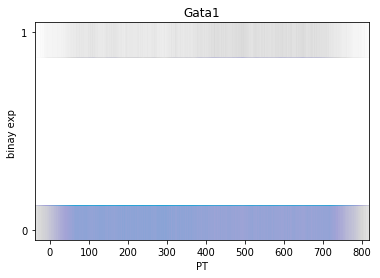

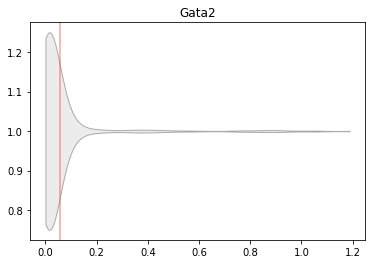

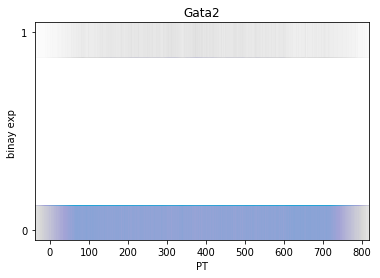

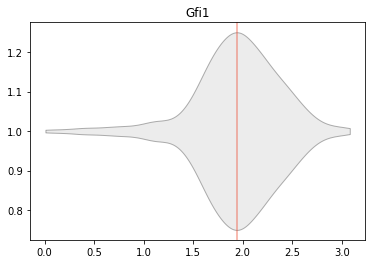

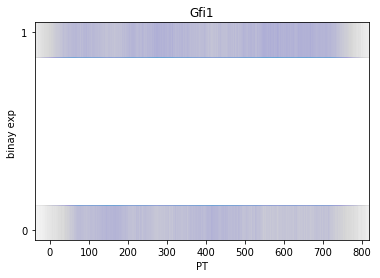

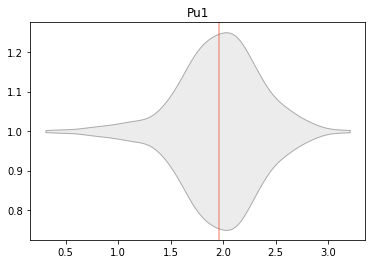

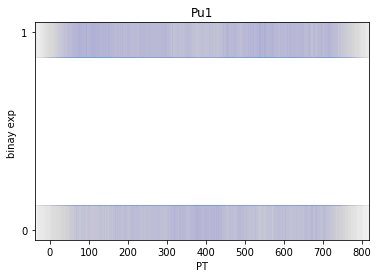

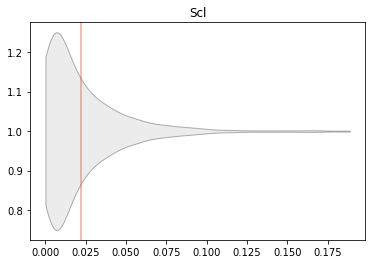

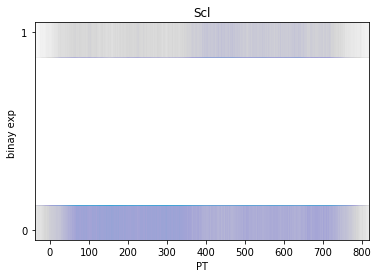

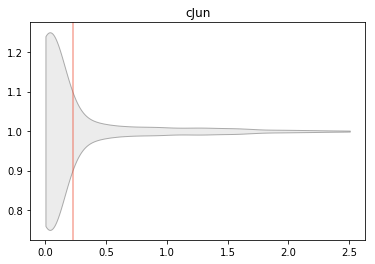

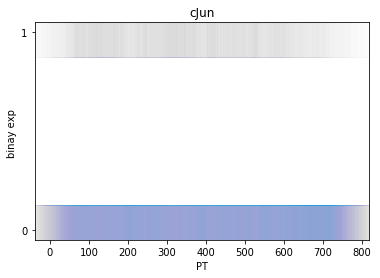

K-mean method threshlding


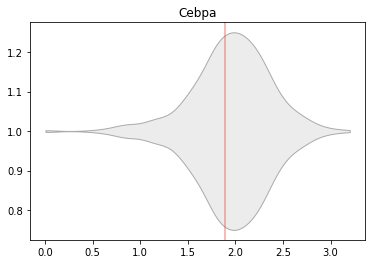

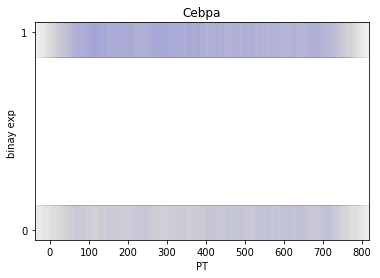

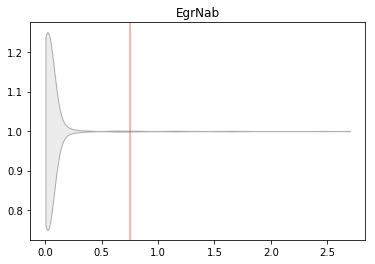

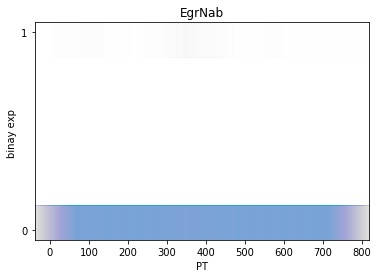

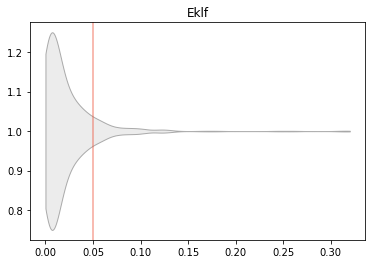

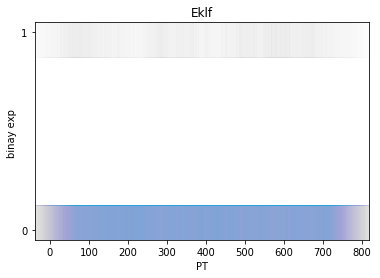

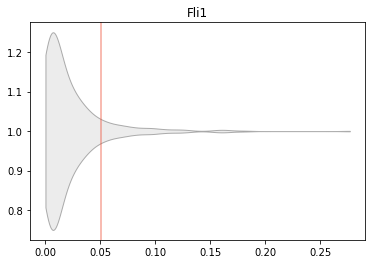

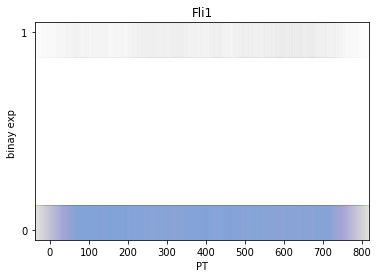

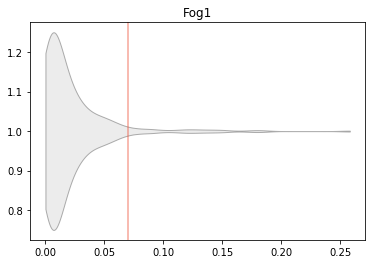

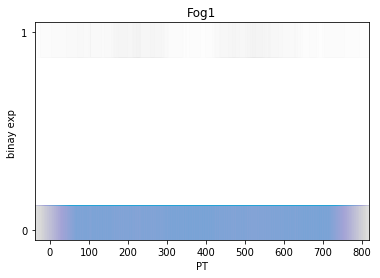

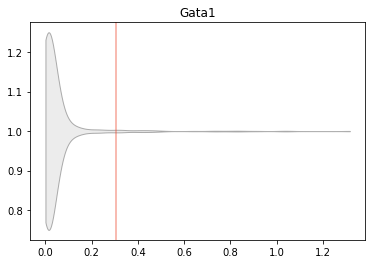

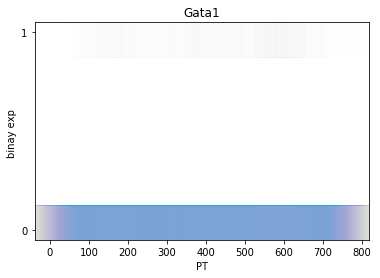

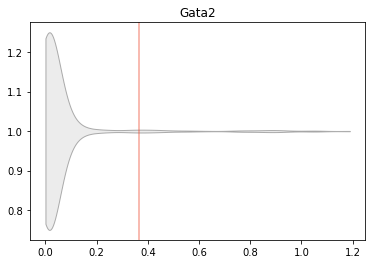

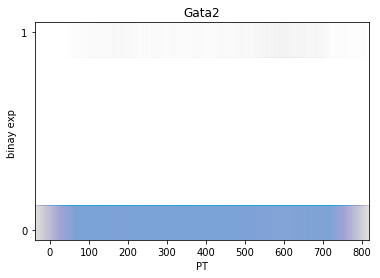

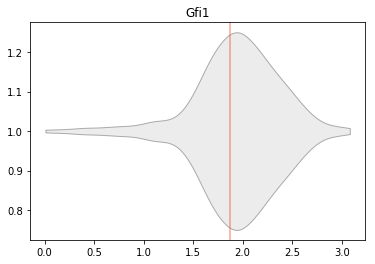

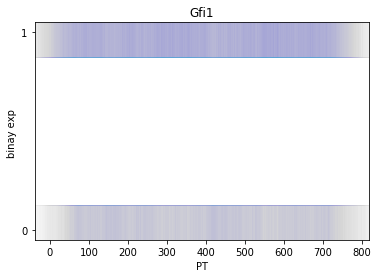

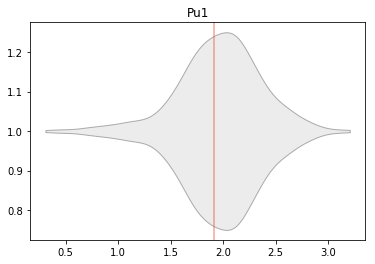

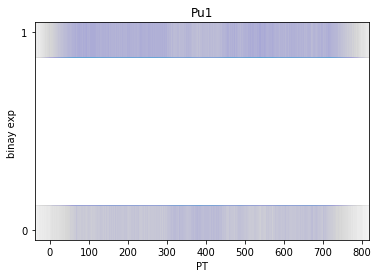

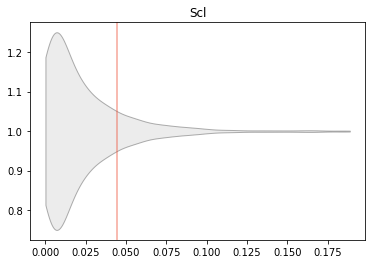

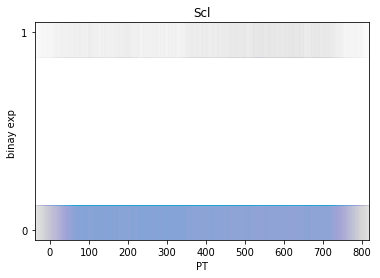

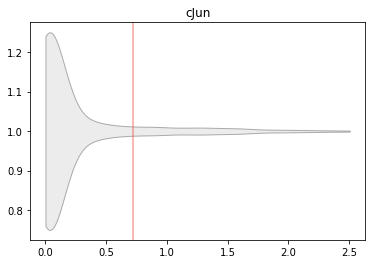

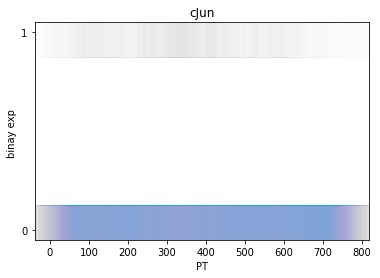

Mean method threshlding


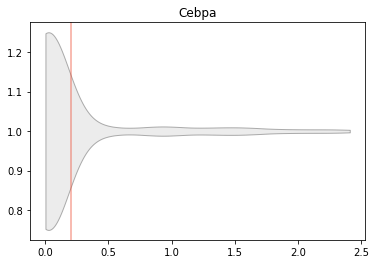

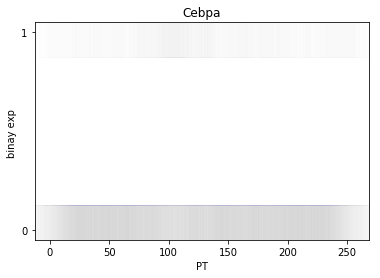

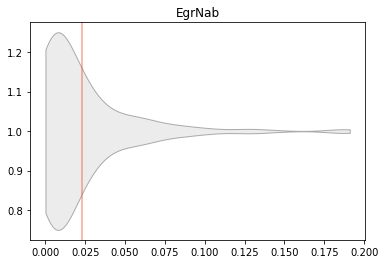

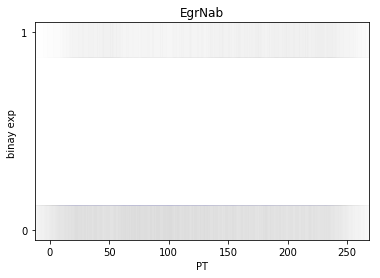

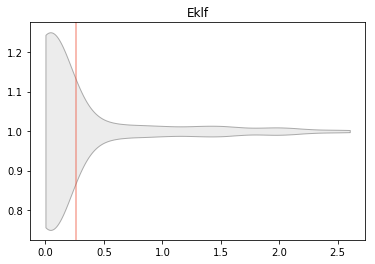

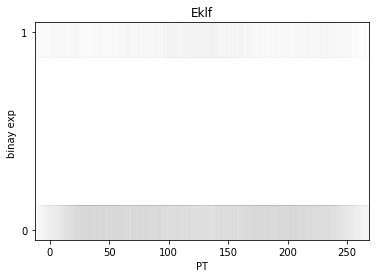

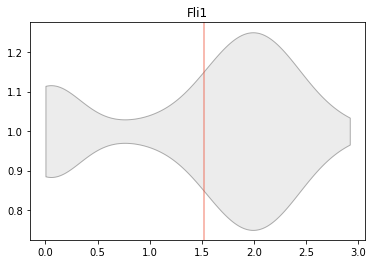

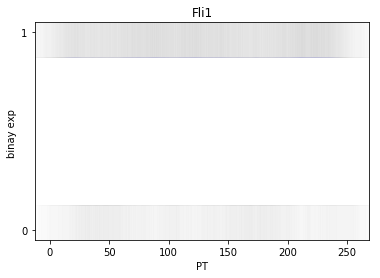

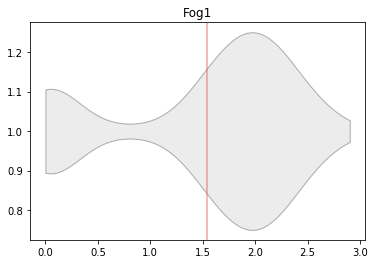

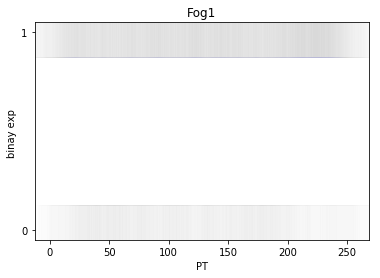

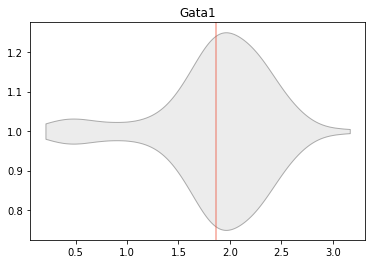

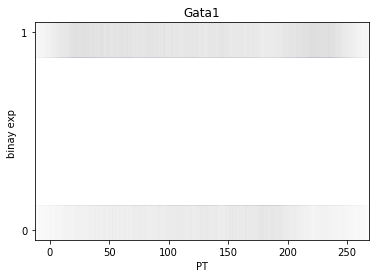

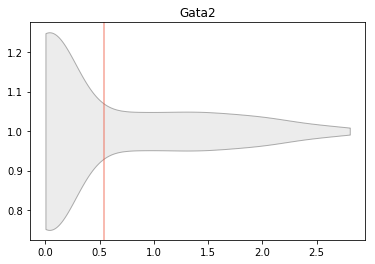

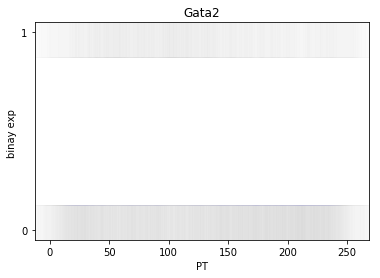

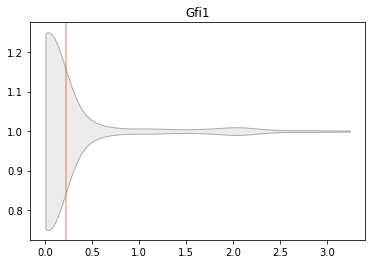

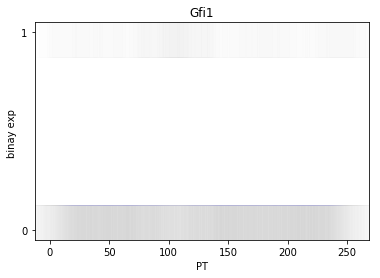

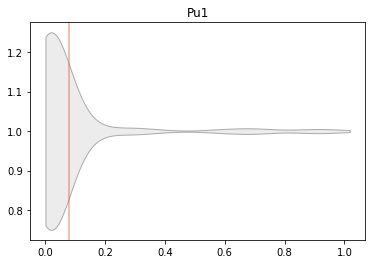

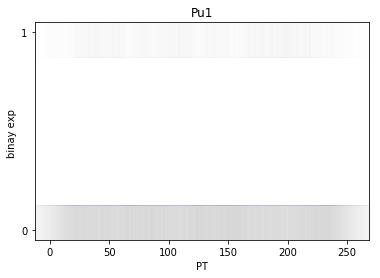

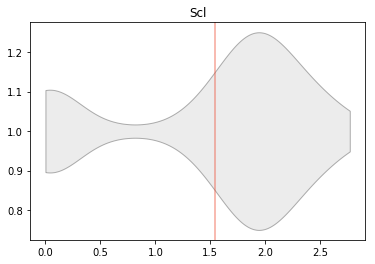

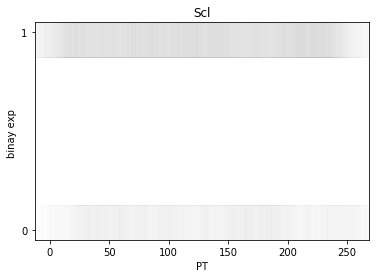

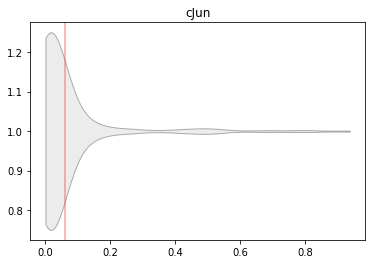

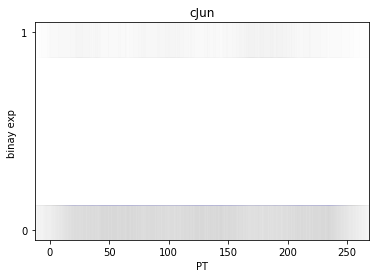

K-mean method threshlding


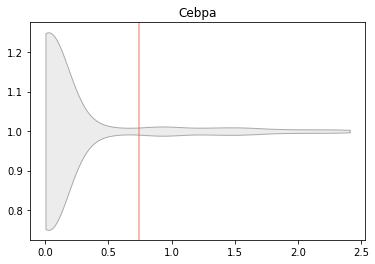

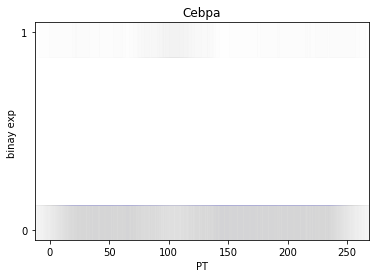

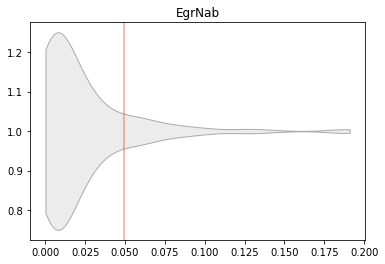

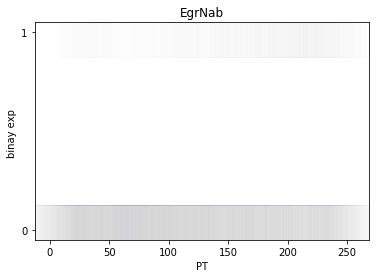

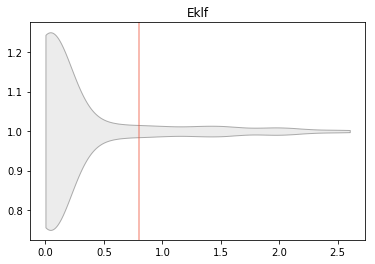

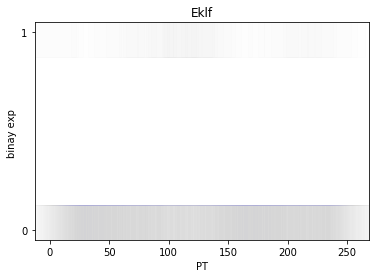

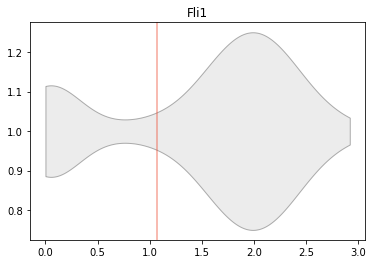

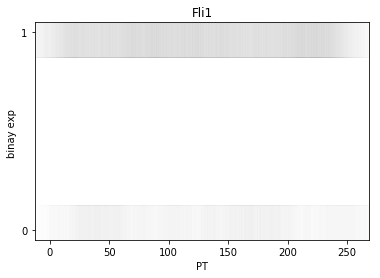

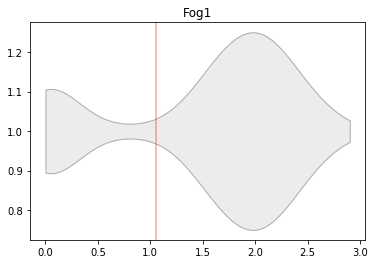

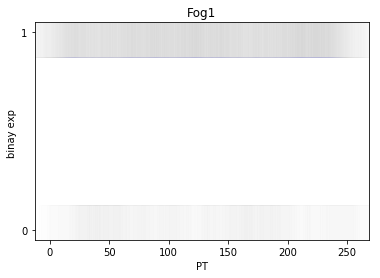

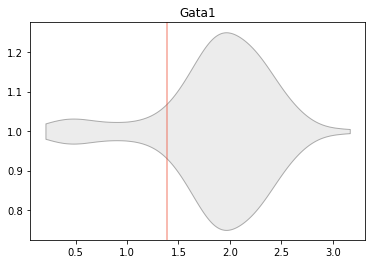

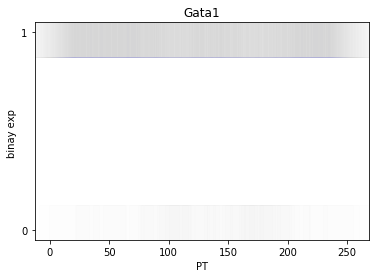

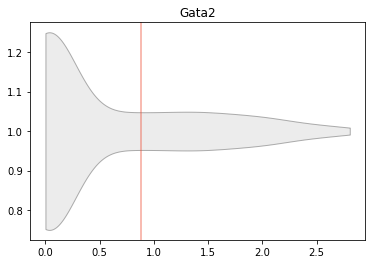

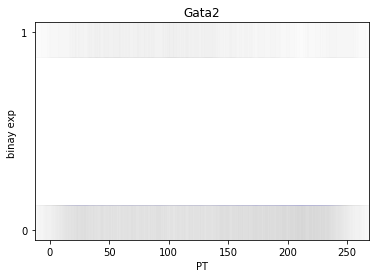

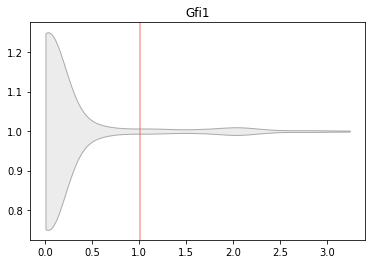

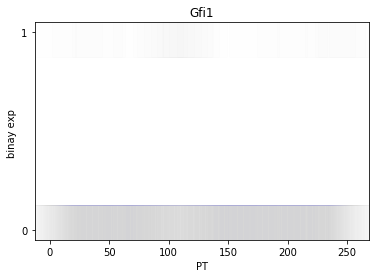

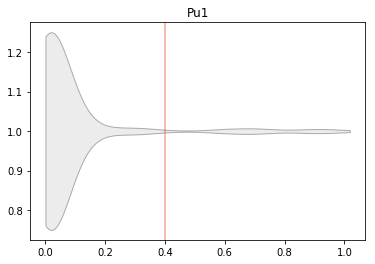

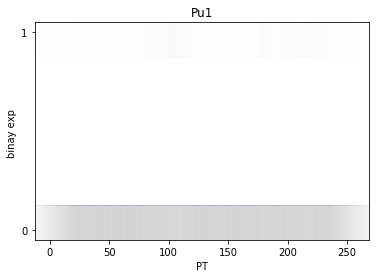

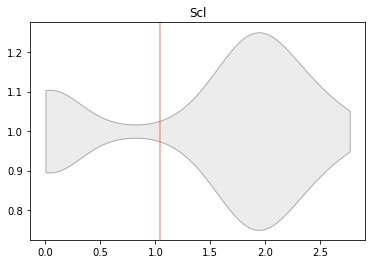

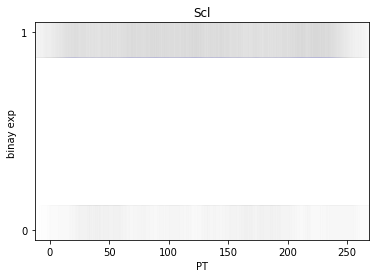

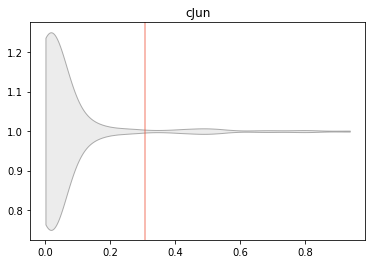

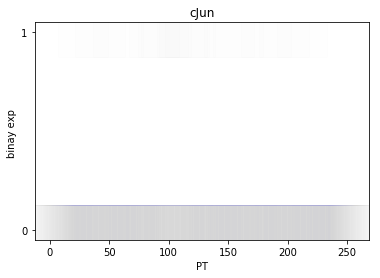

Mean method threshlding


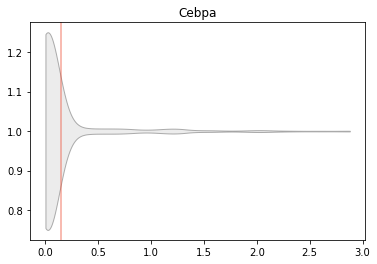

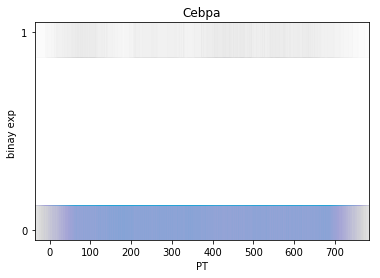

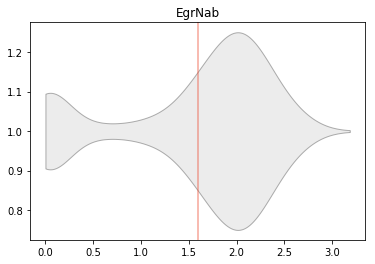

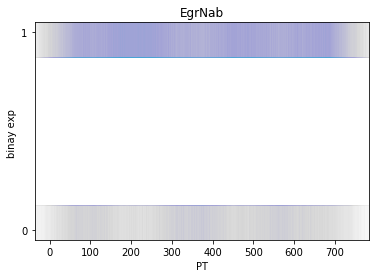

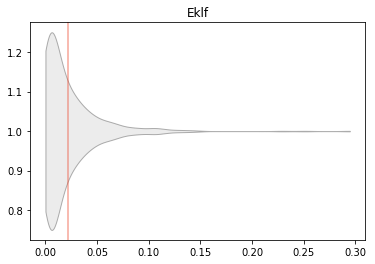

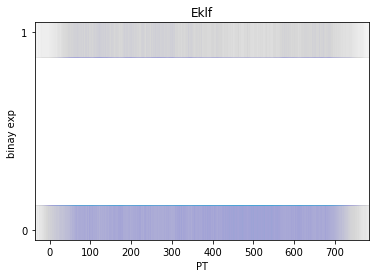

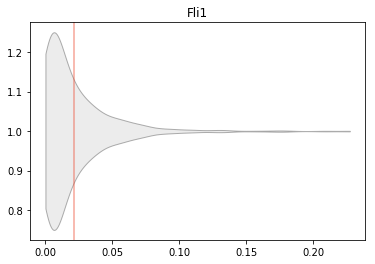

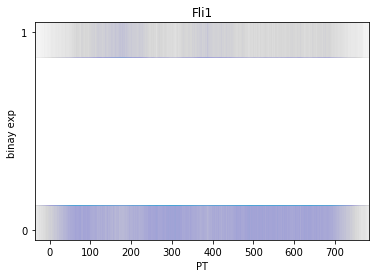

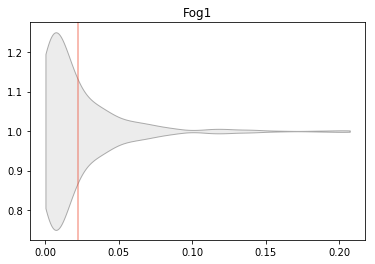

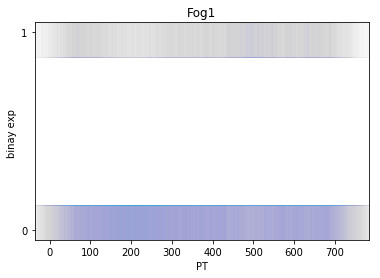

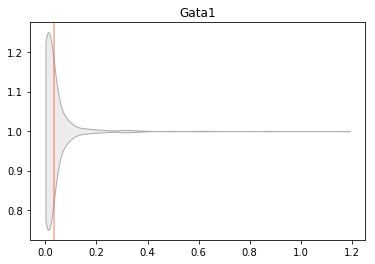

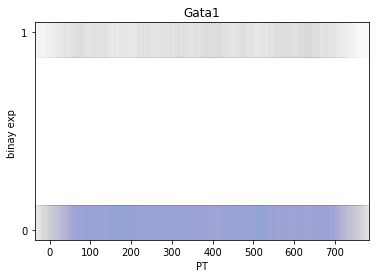

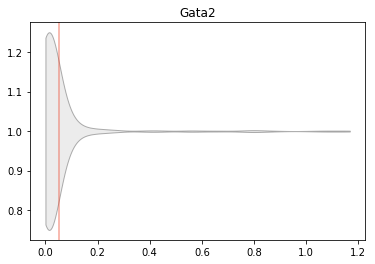

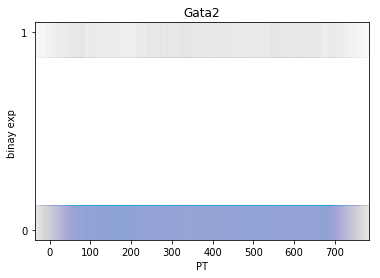

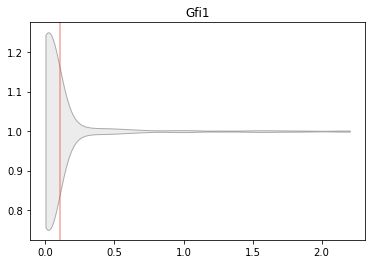

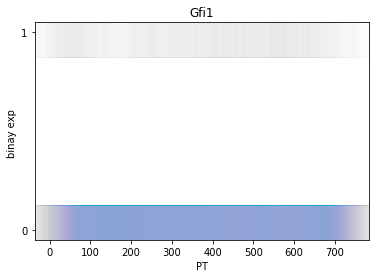

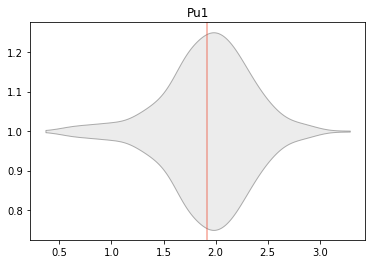

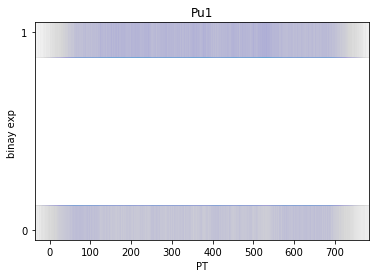

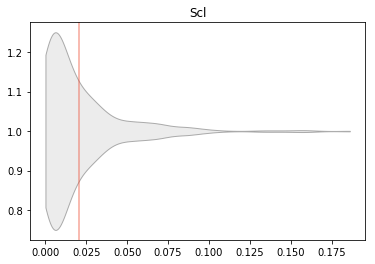

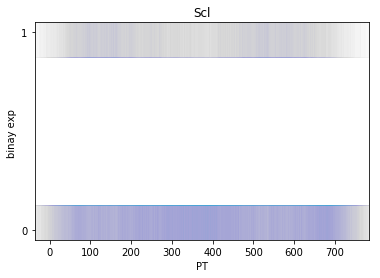

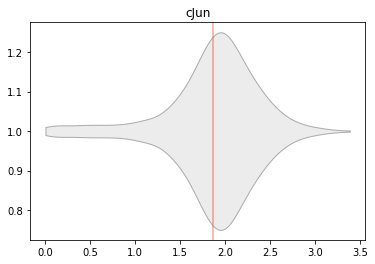

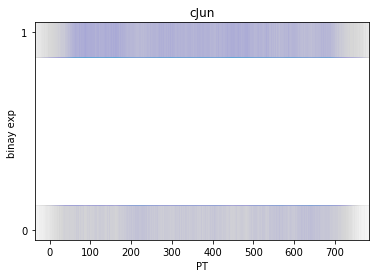

K-mean method threshlding


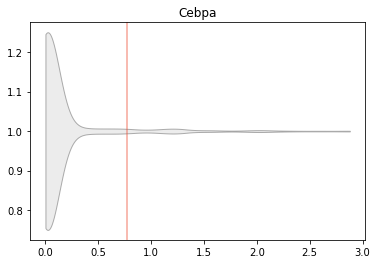

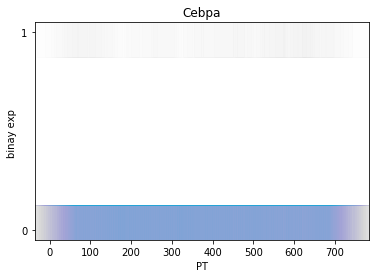

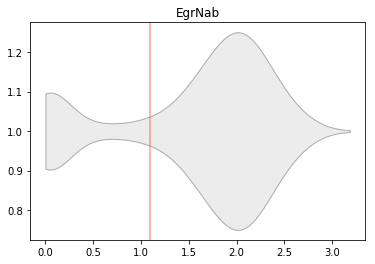

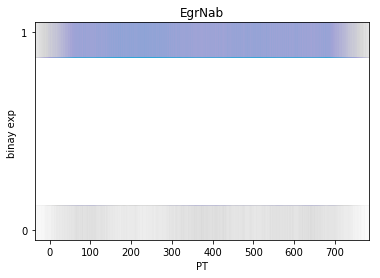

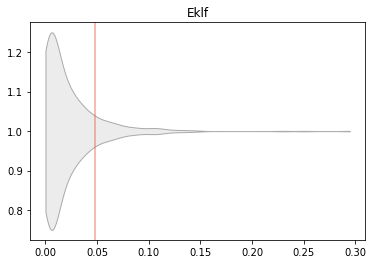

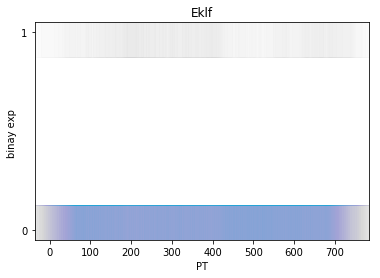

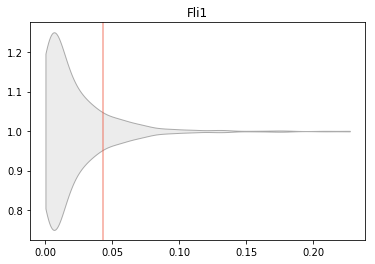

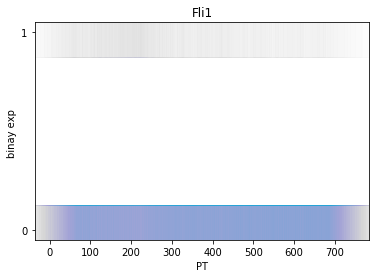

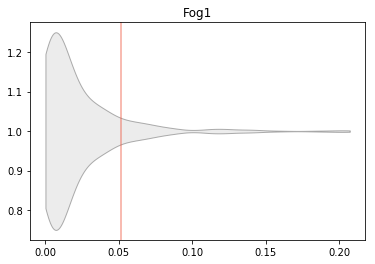

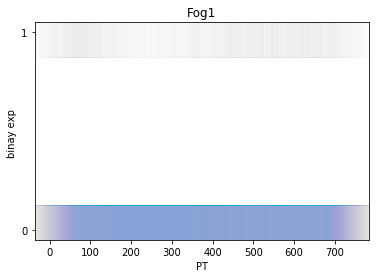

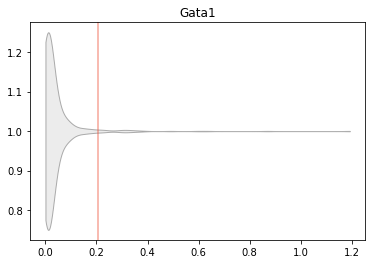

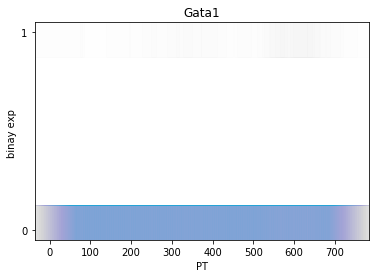

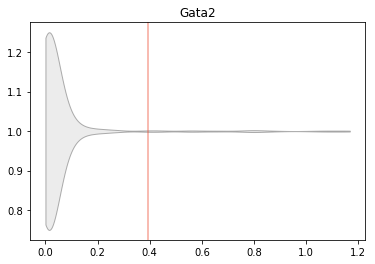

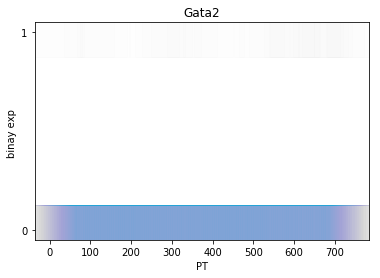

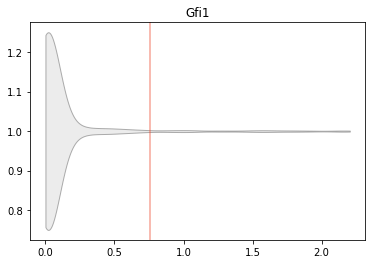

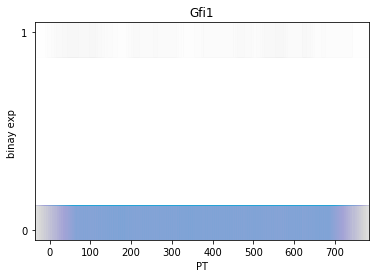

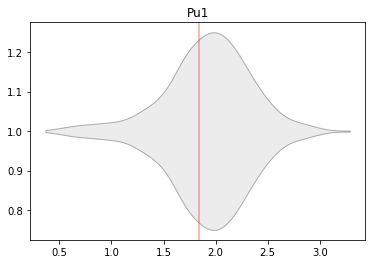

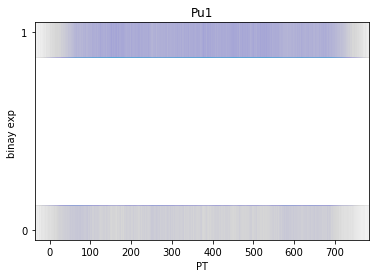

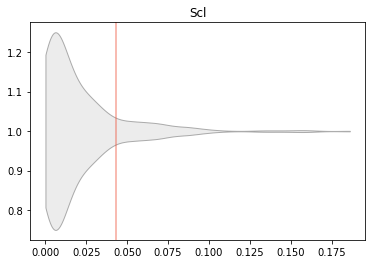

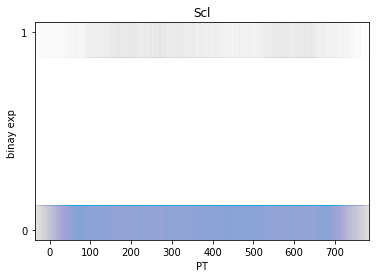

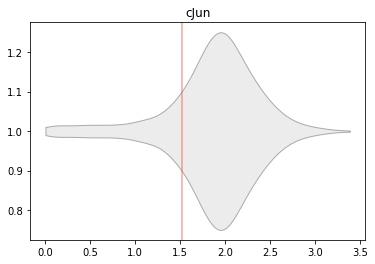

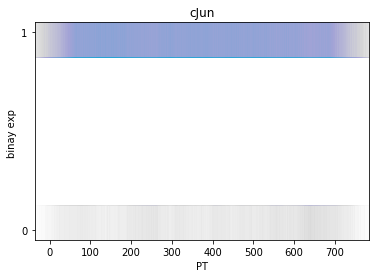

Mean method threshlding


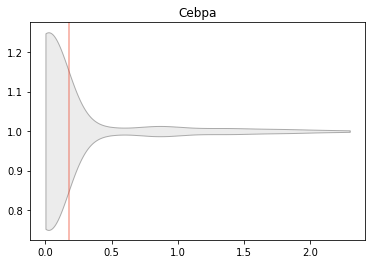

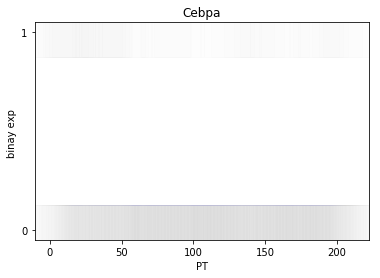

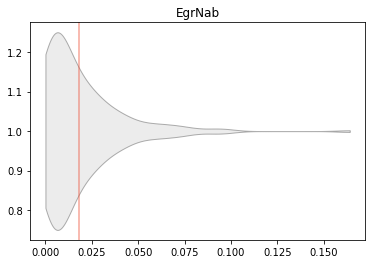

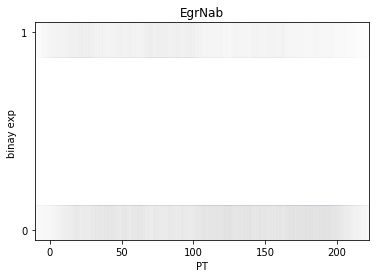

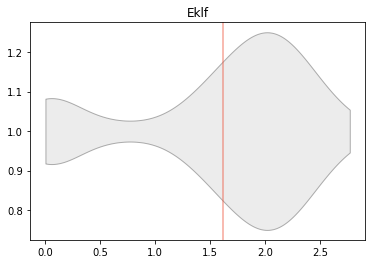

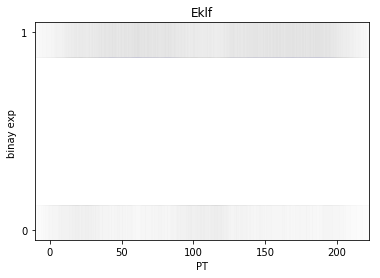

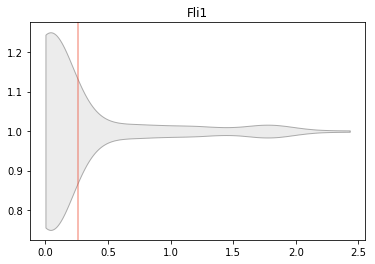

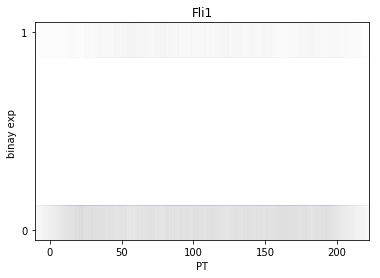

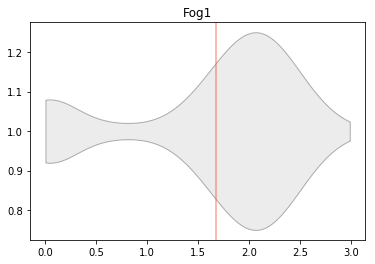

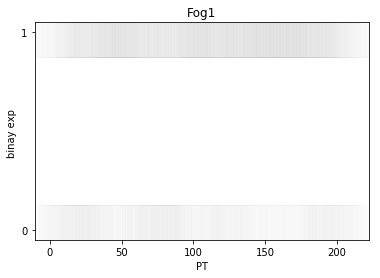

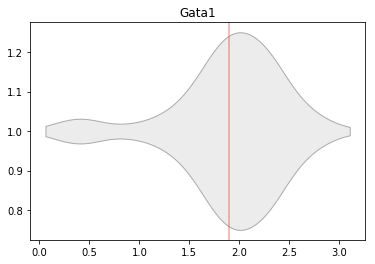

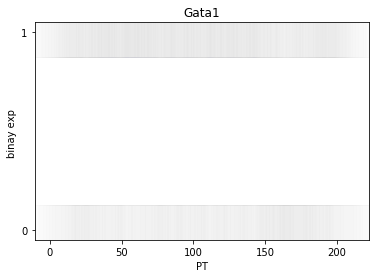

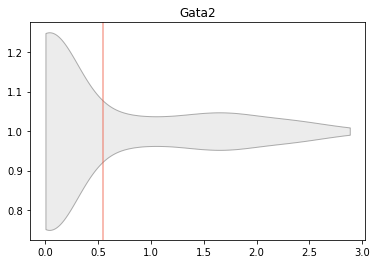

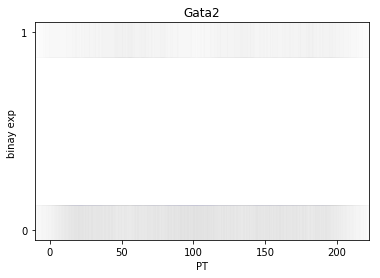

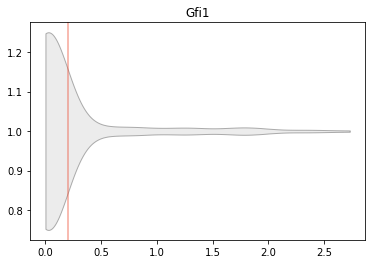

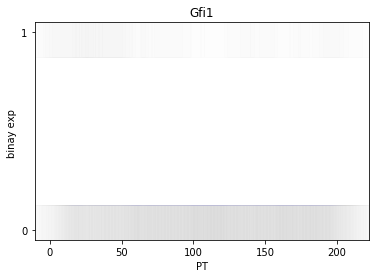

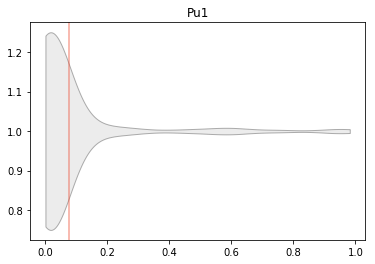

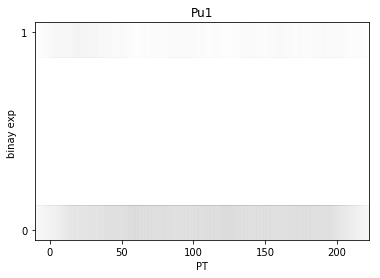

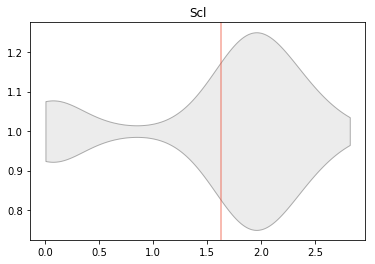

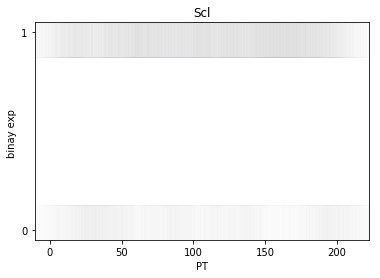

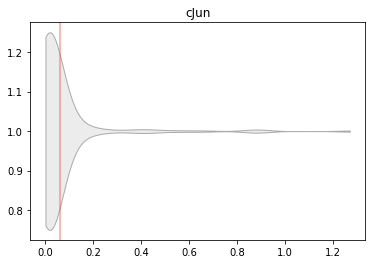

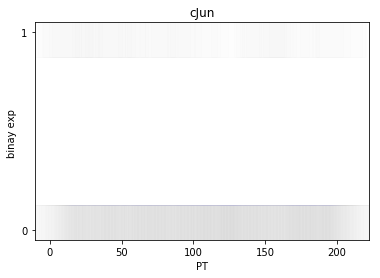

K-mean method threshlding


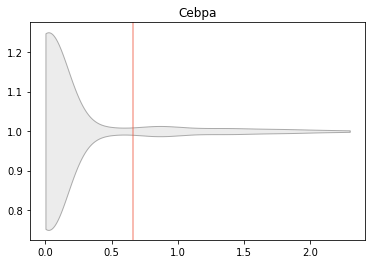

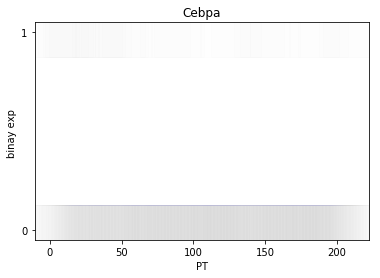

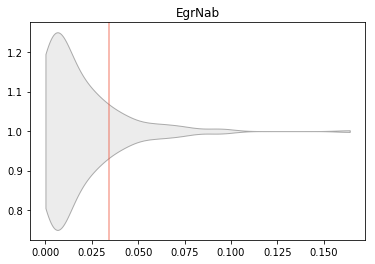

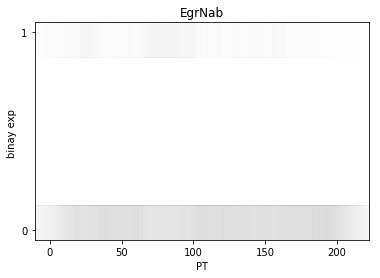

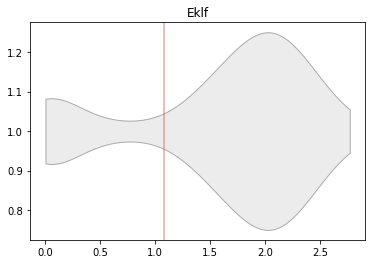

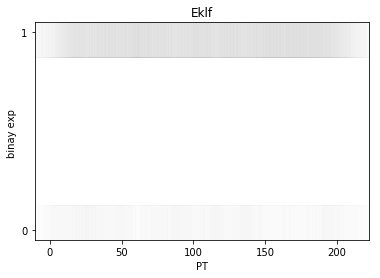

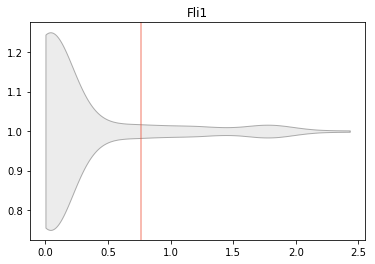

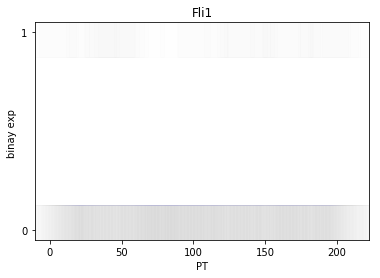

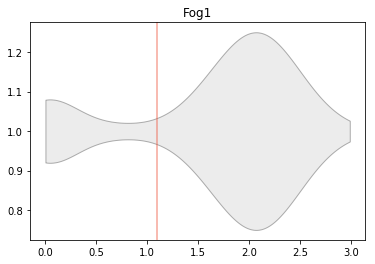

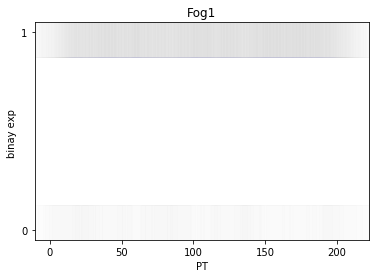

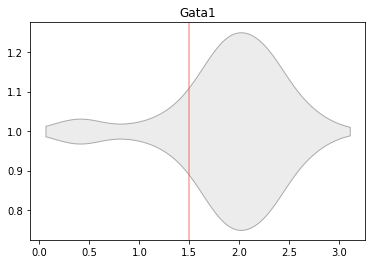

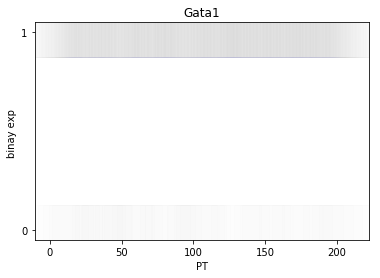

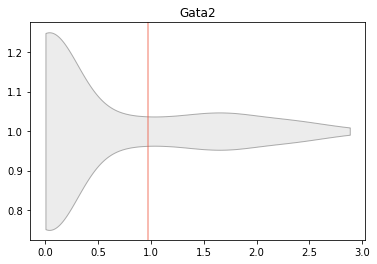

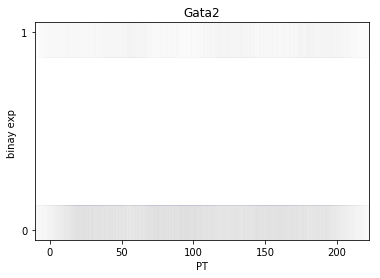

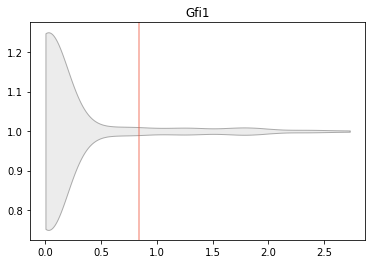

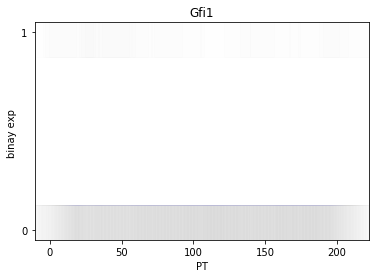

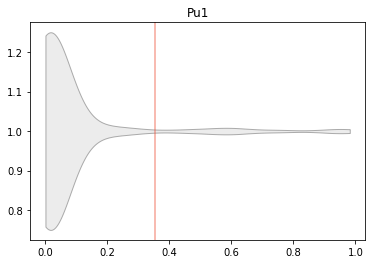

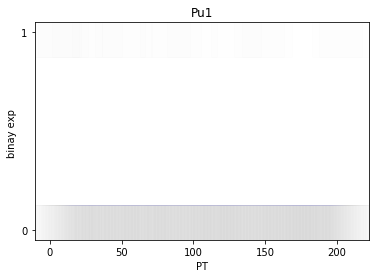

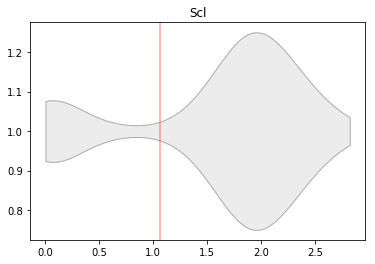

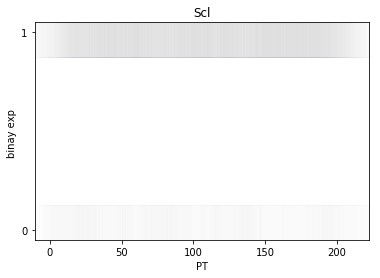

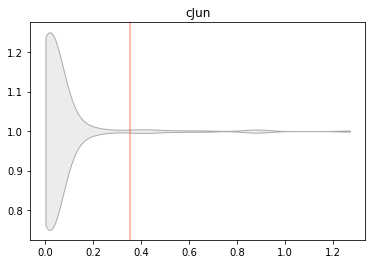

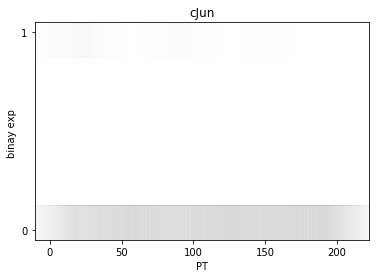

Mean method threshlding


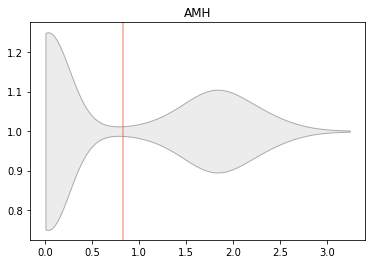

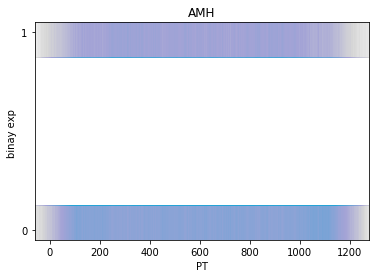

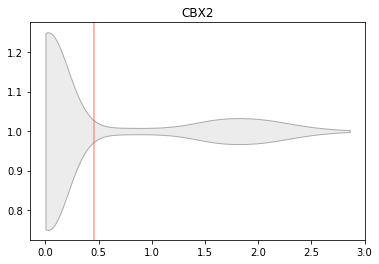

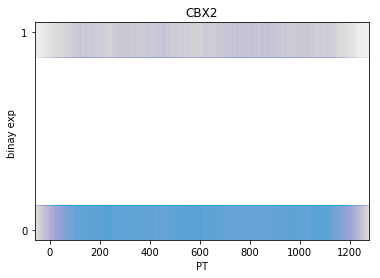

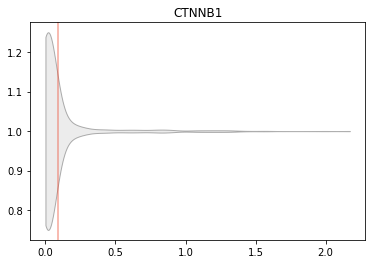

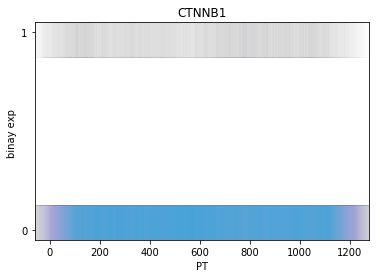

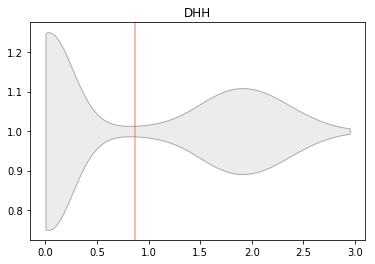

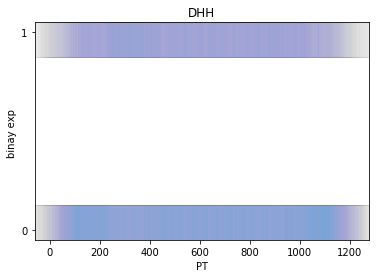

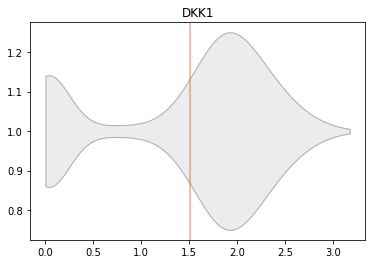

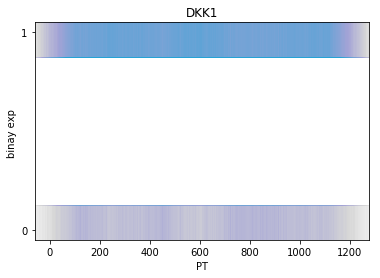

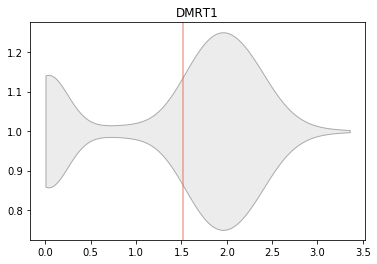

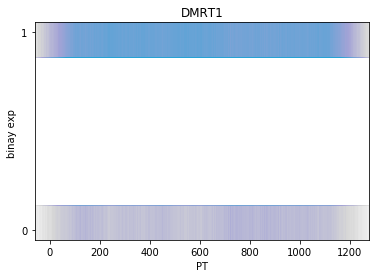

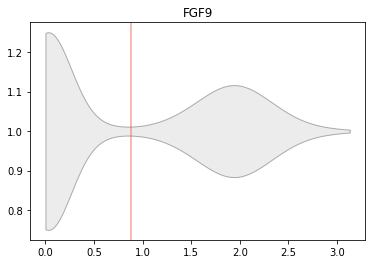

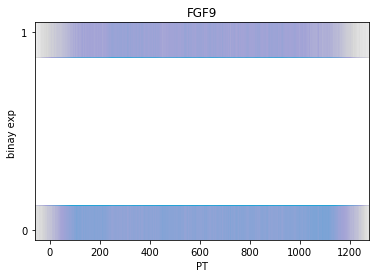

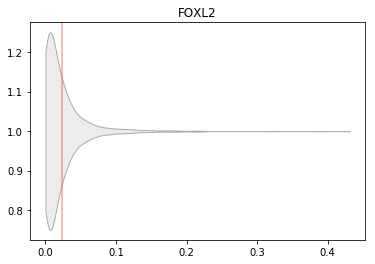

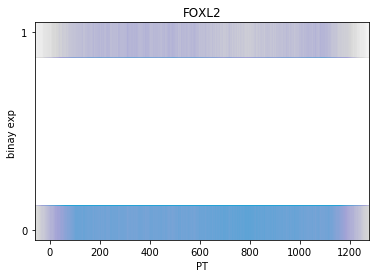

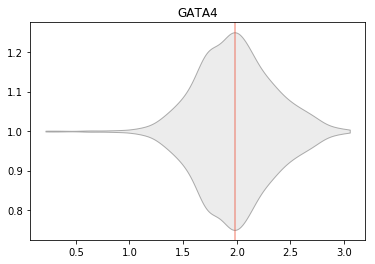

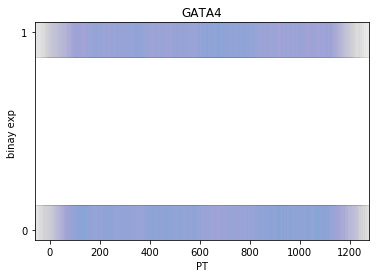

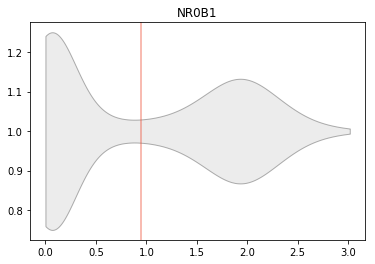

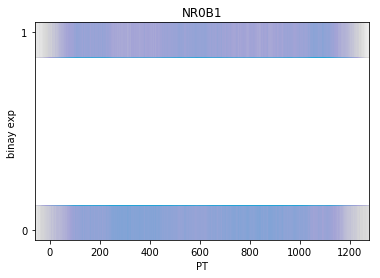

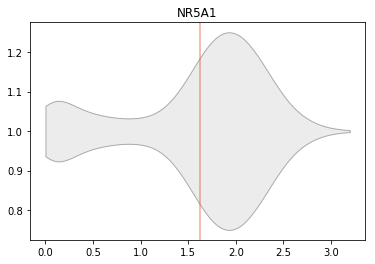

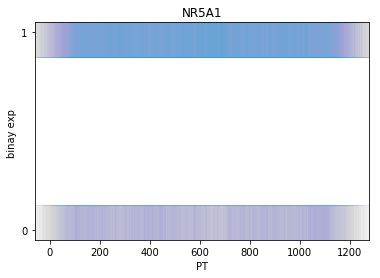

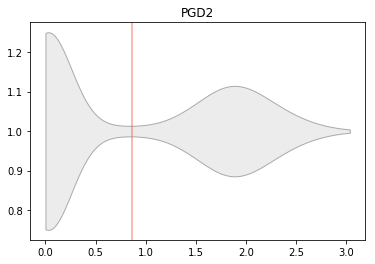

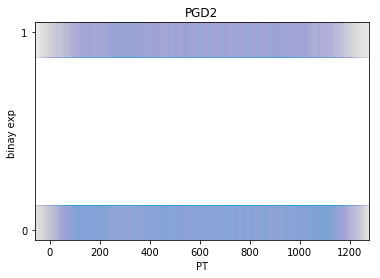

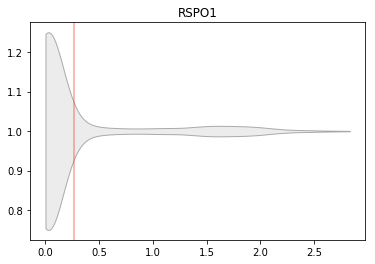

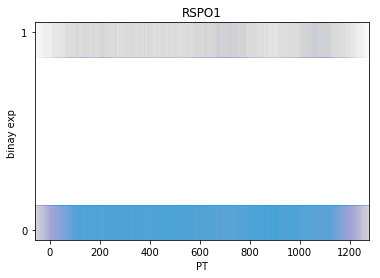

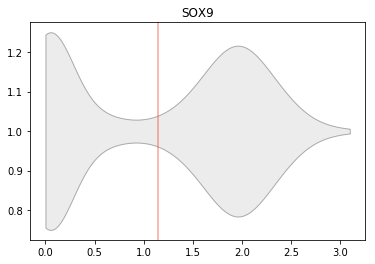

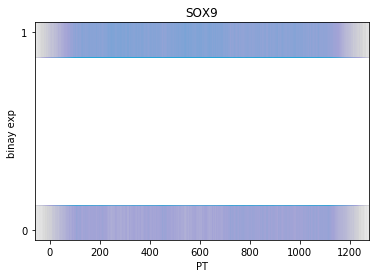

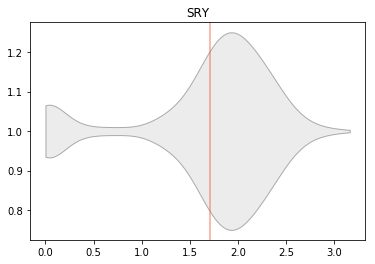

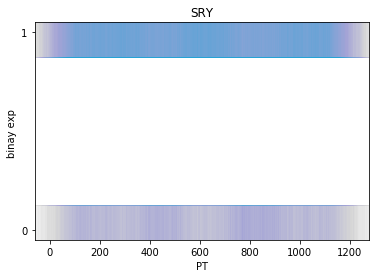

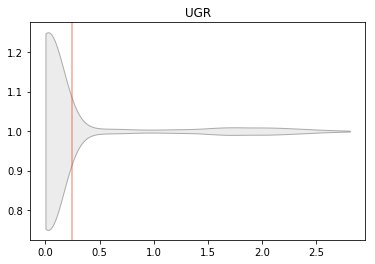

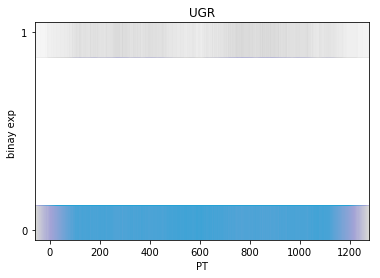

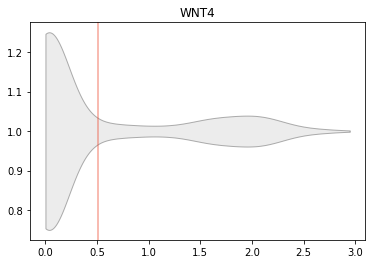

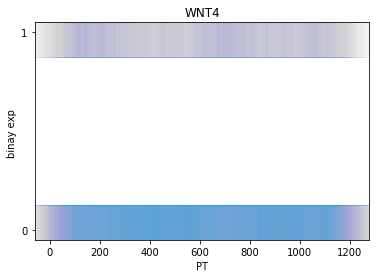

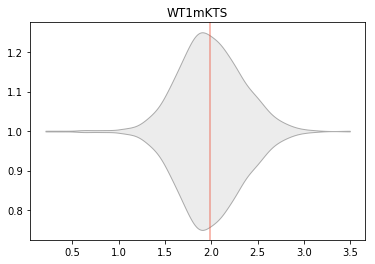

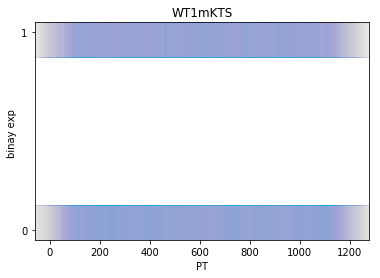

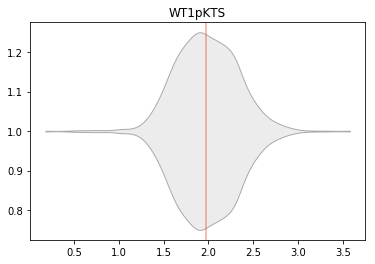

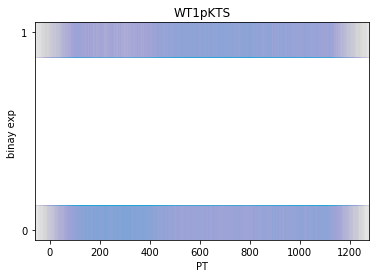

K-mean method threshlding


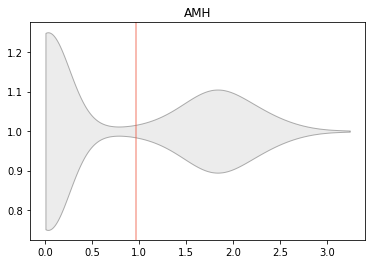

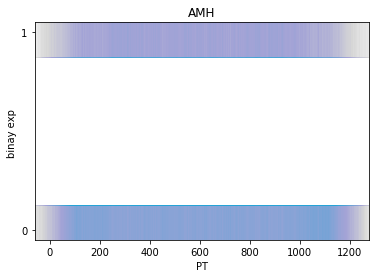

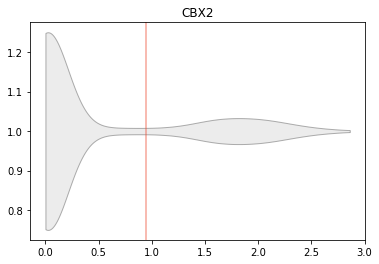

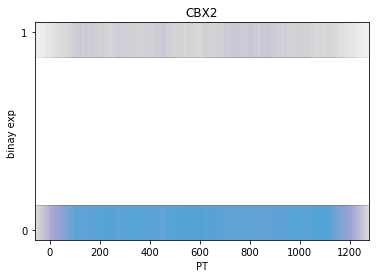

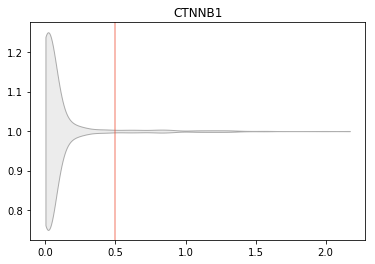

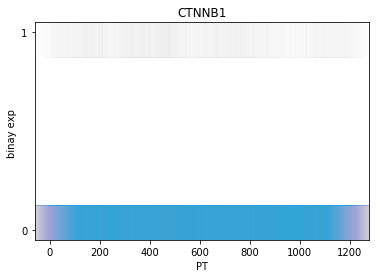

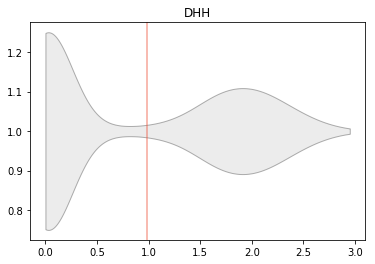

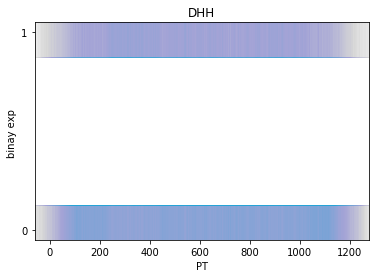

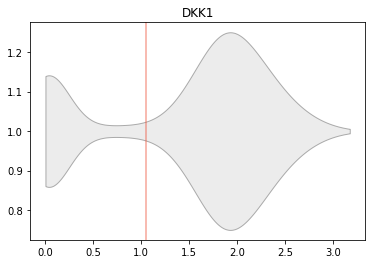

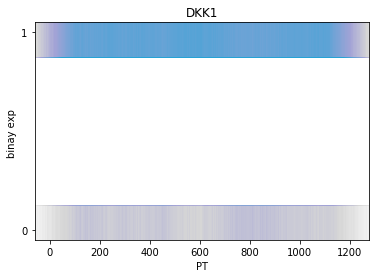

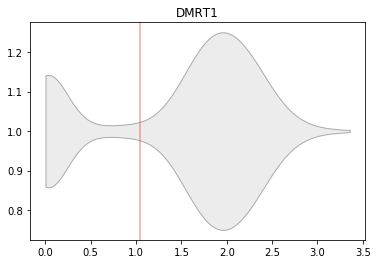

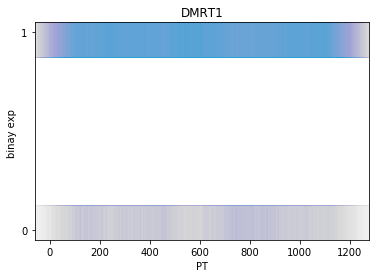

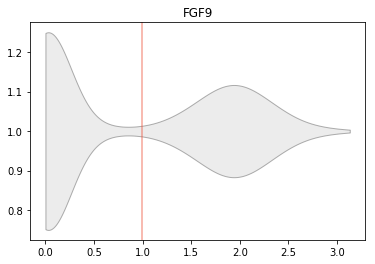

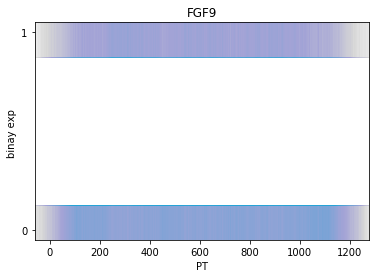

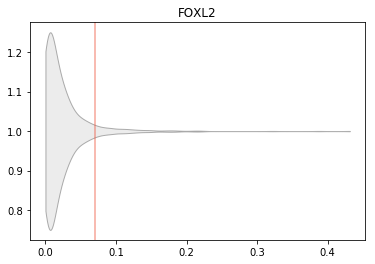

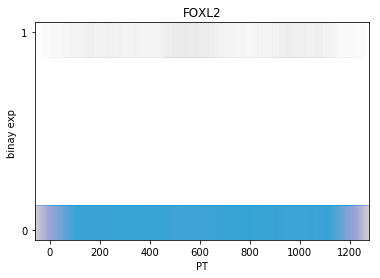

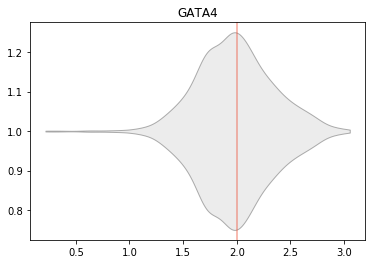

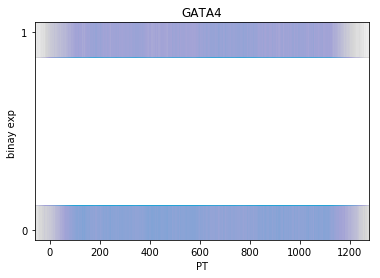

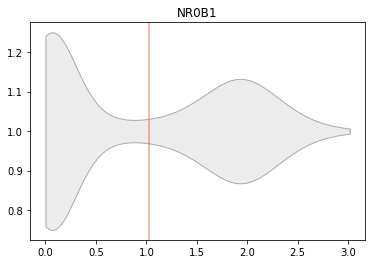

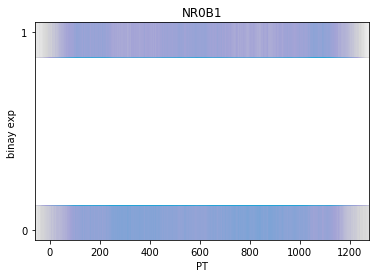

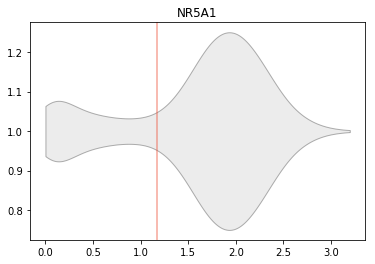

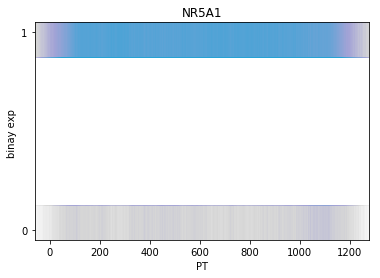

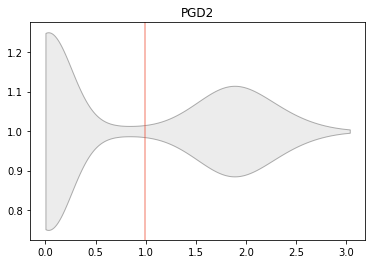

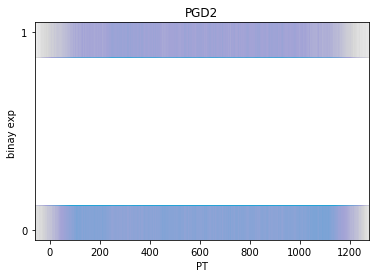

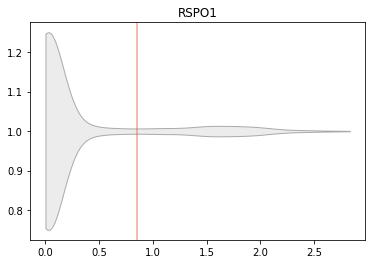

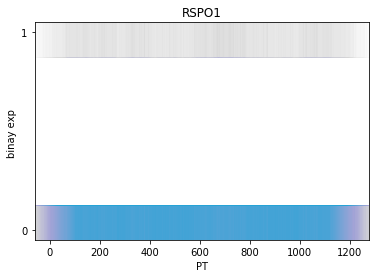

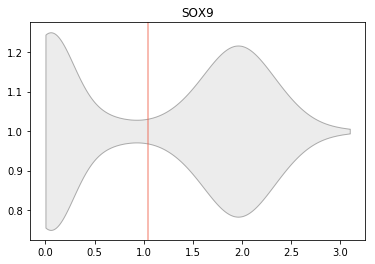

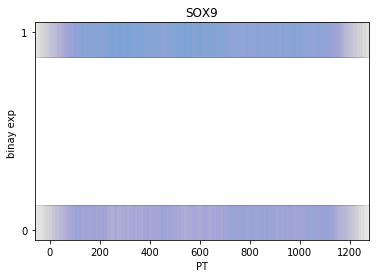

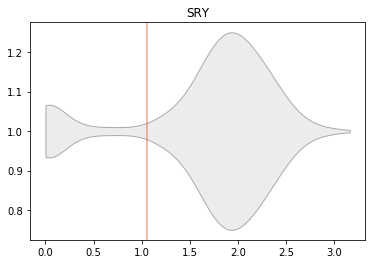

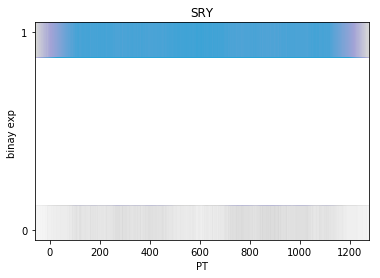

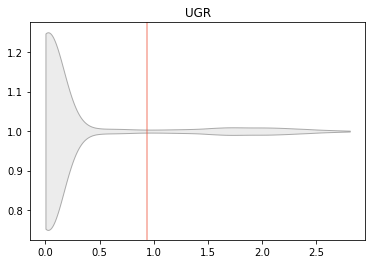

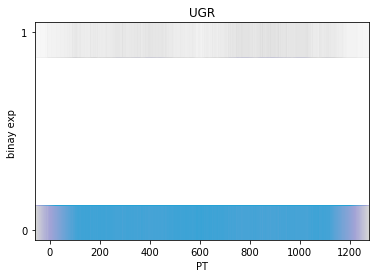

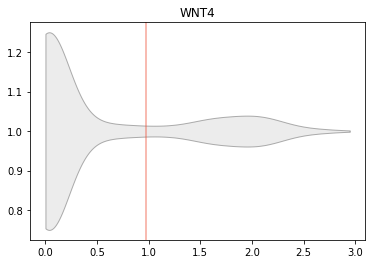

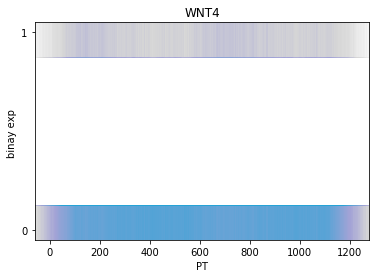

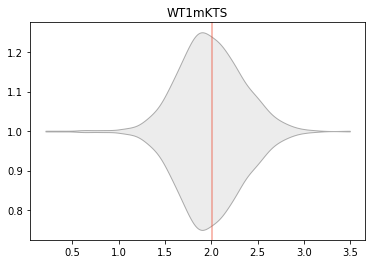

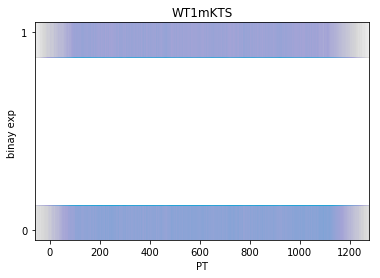

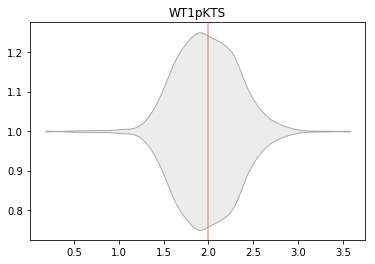

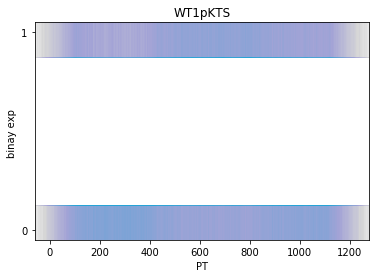

Mean method threshlding


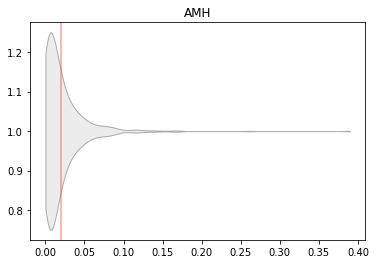

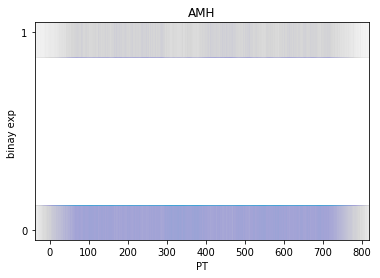

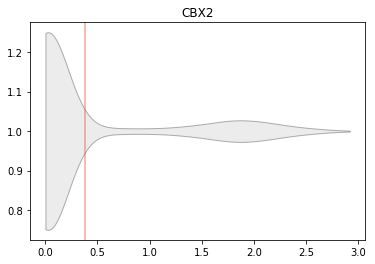

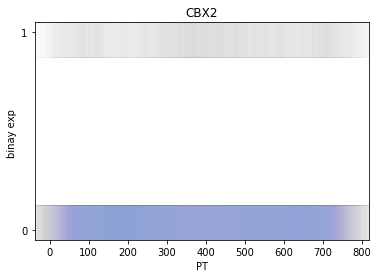

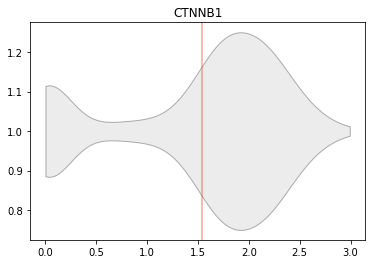

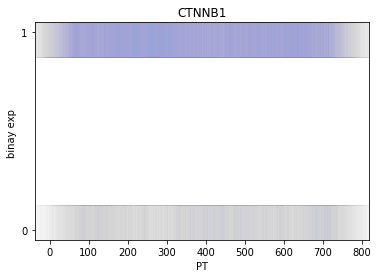

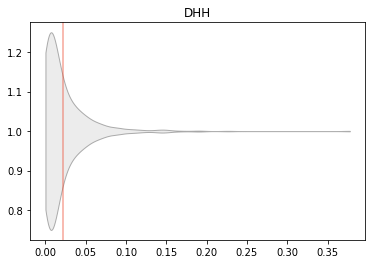

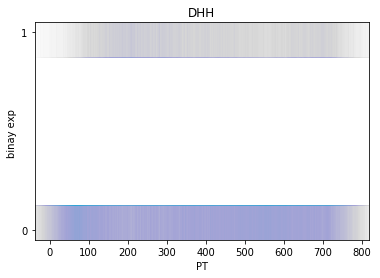

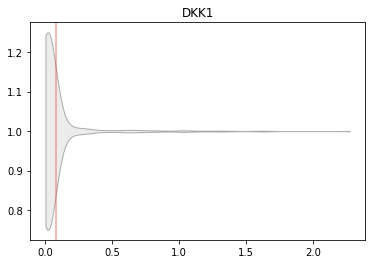

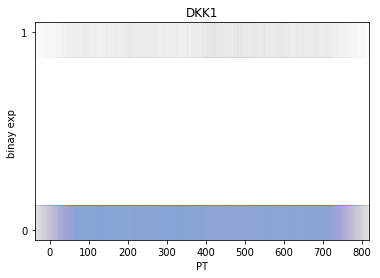

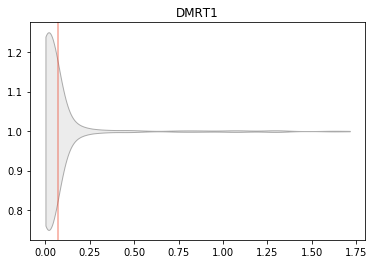

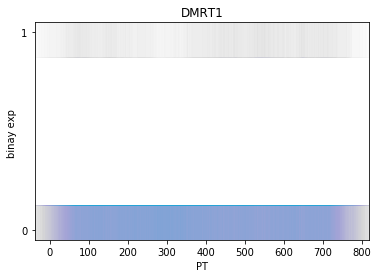

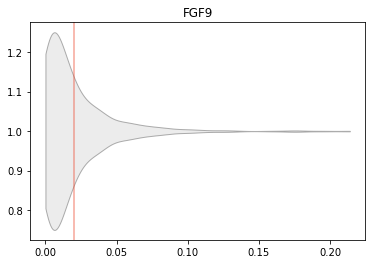

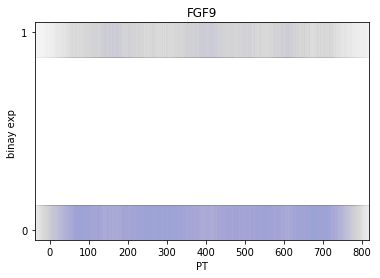

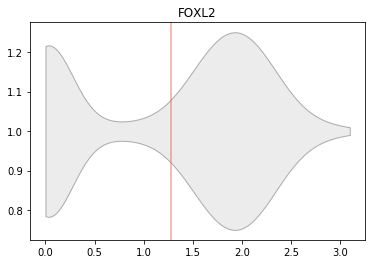

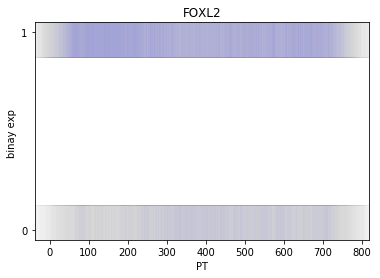

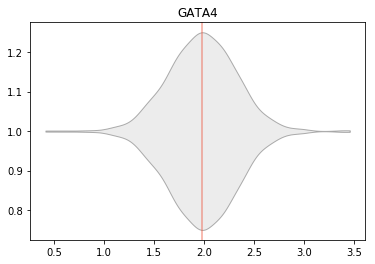

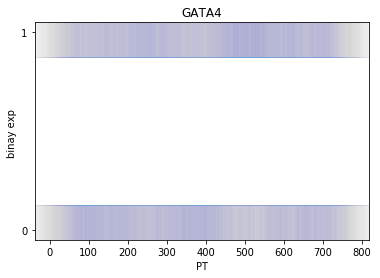

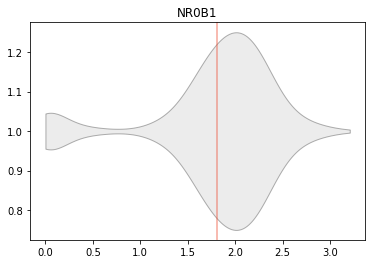

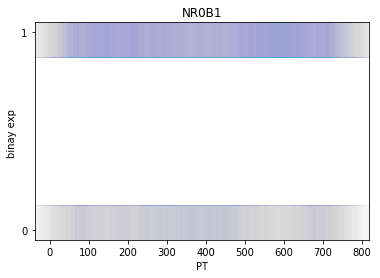

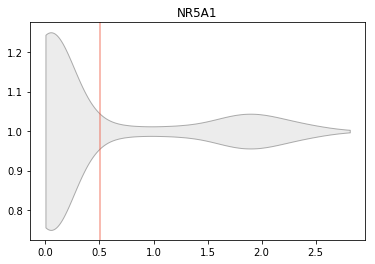

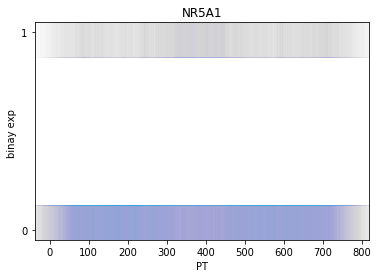

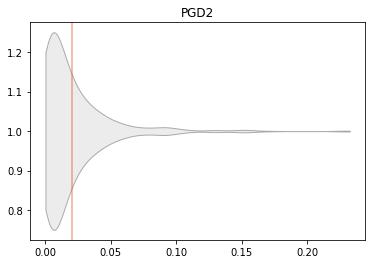

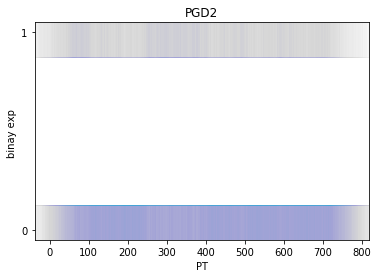

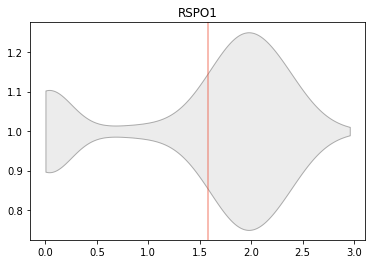

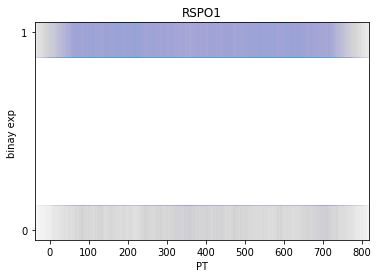

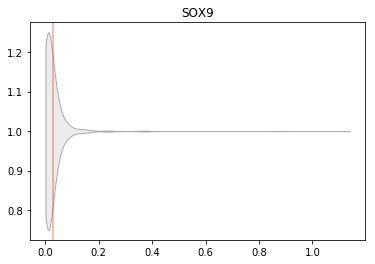

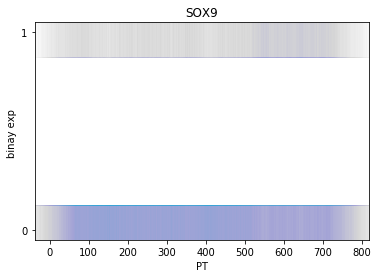

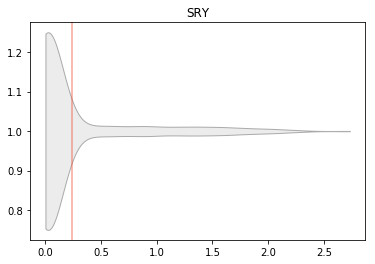

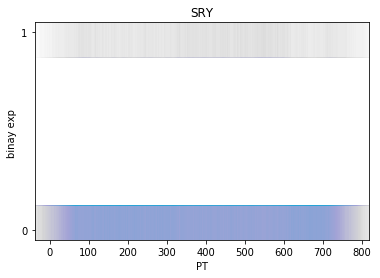

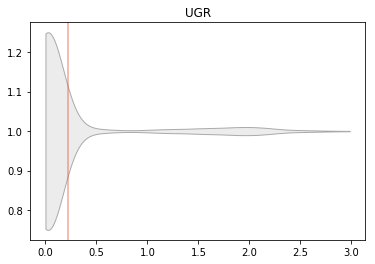

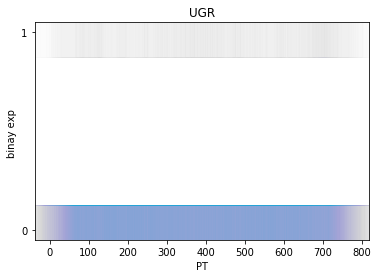

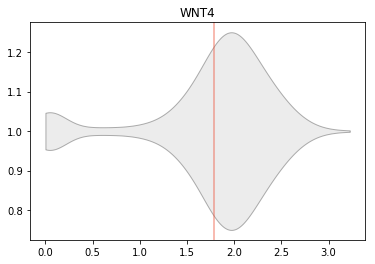

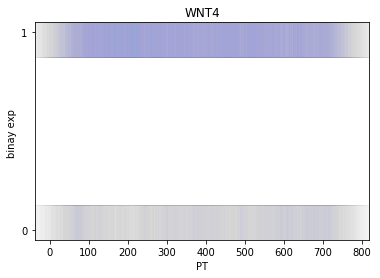

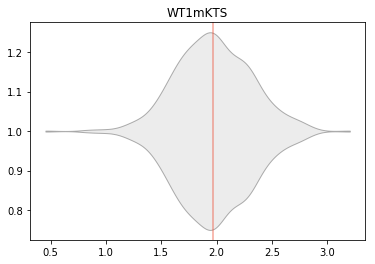

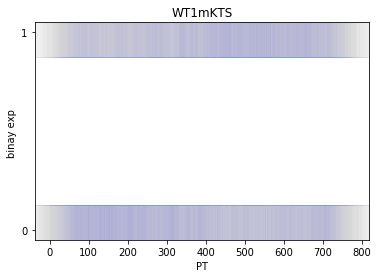

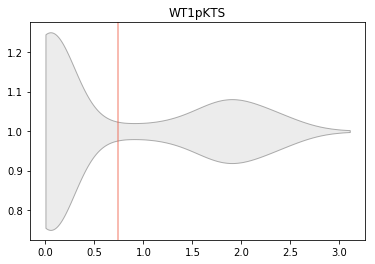

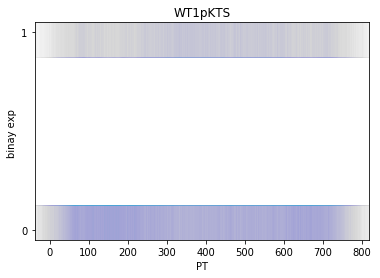

K-mean method threshlding


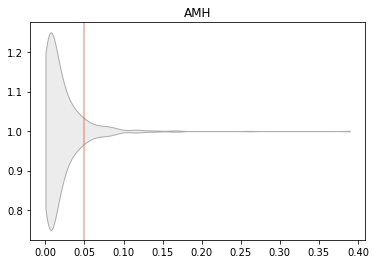

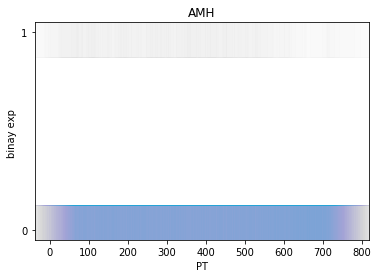

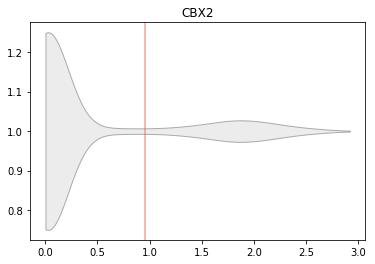

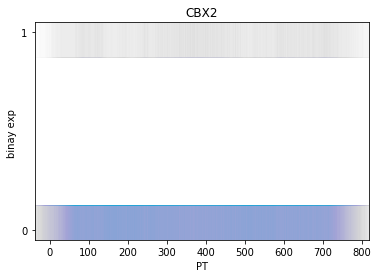

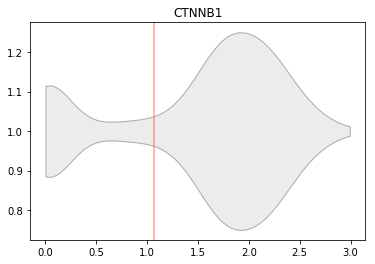

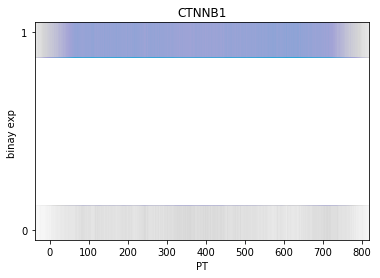

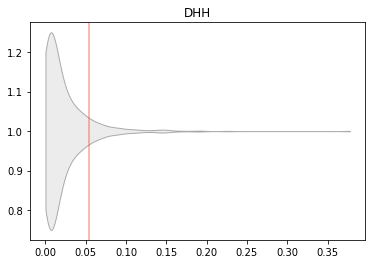

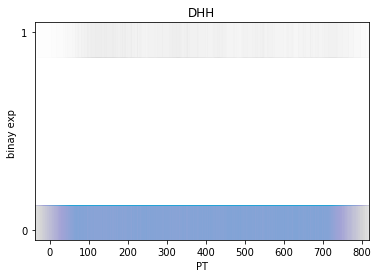

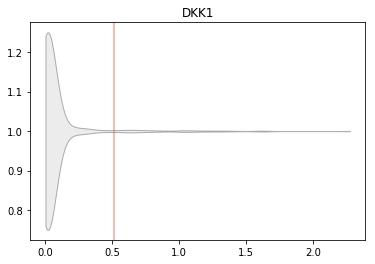

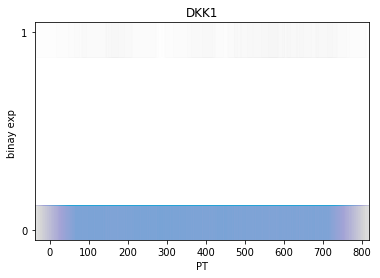

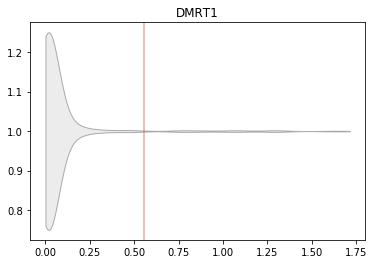

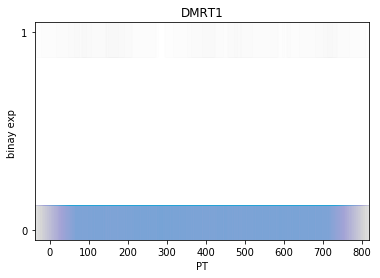

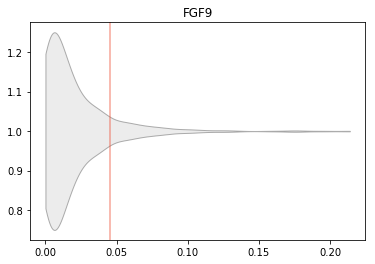

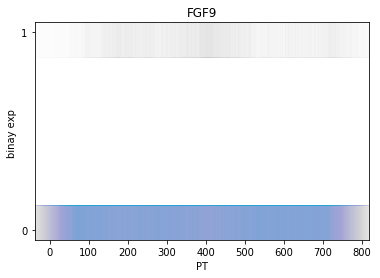

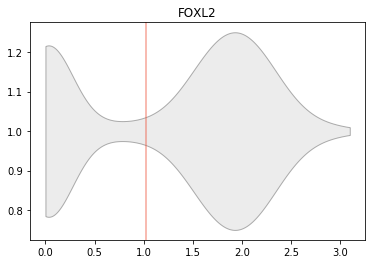

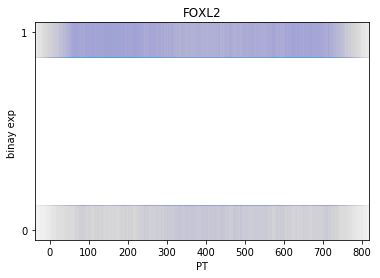

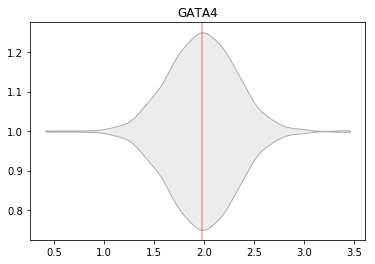

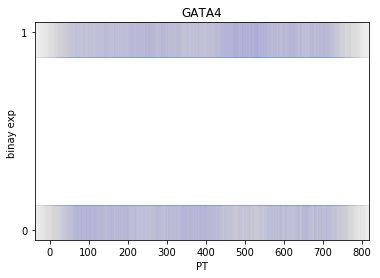

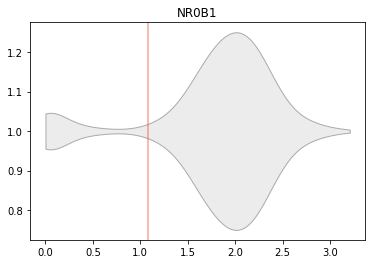

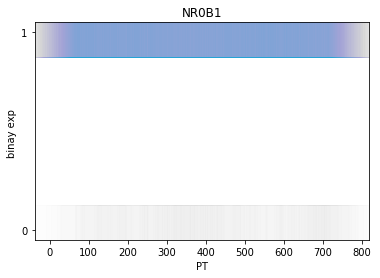

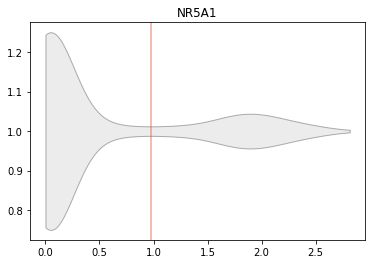

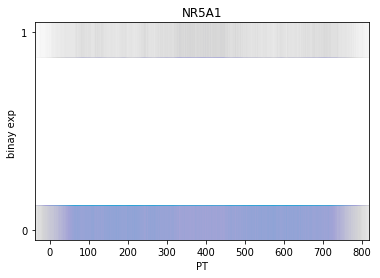

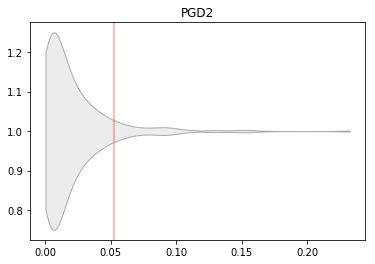

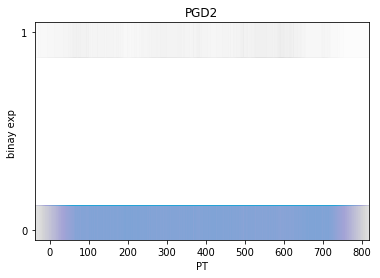

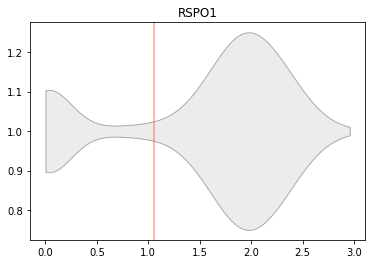

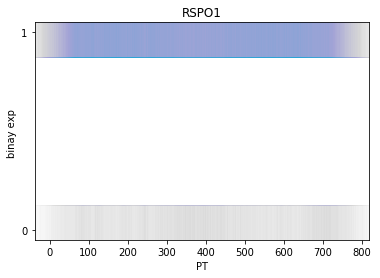

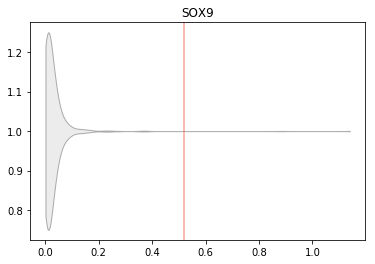

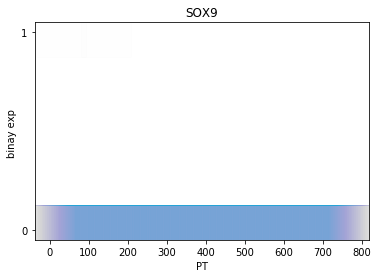

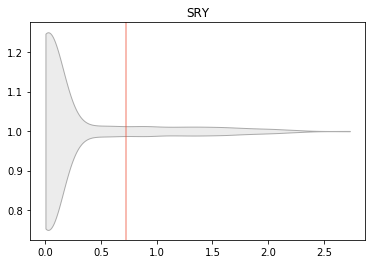

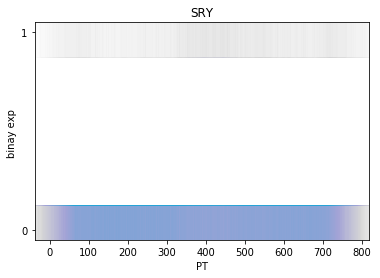

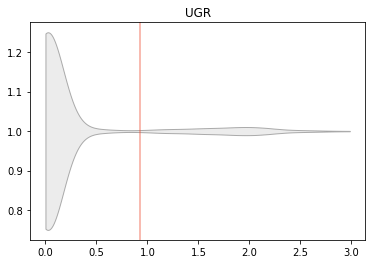

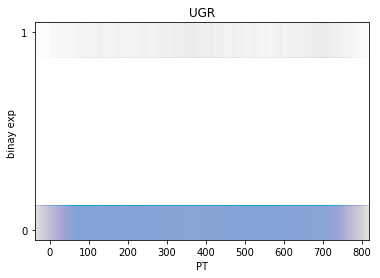

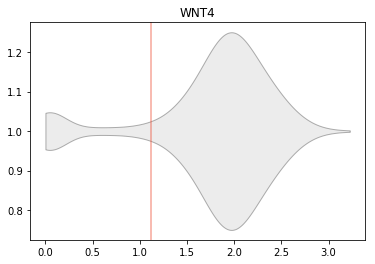

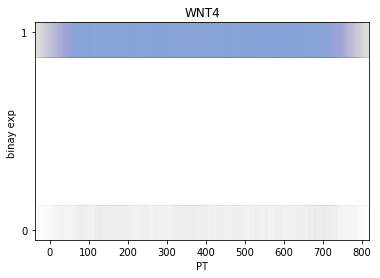

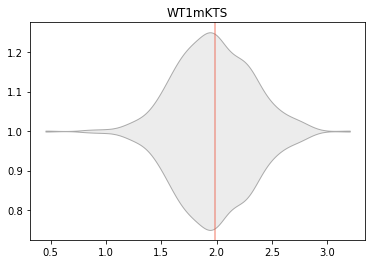

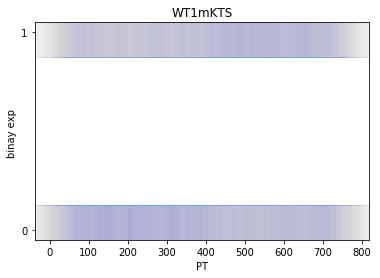

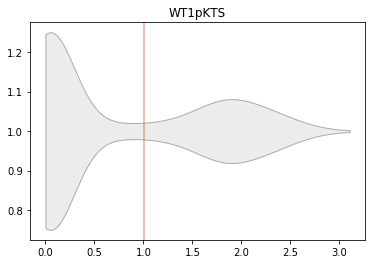

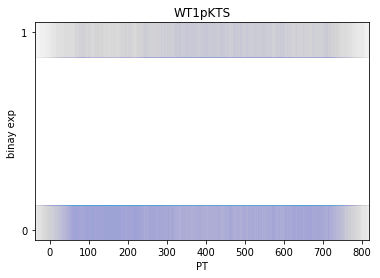

Mean method threshlding


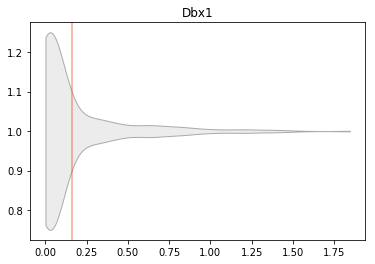

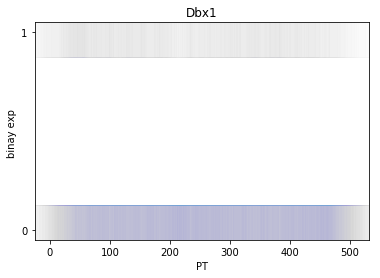

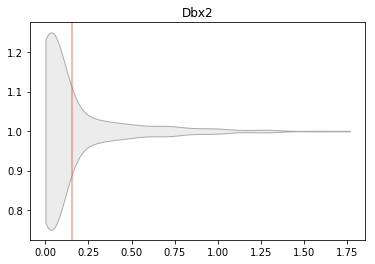

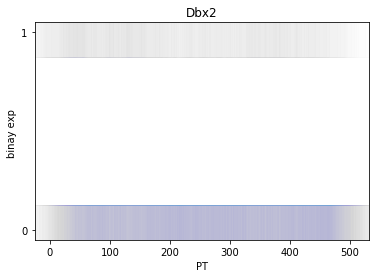

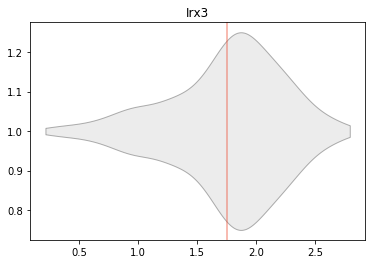

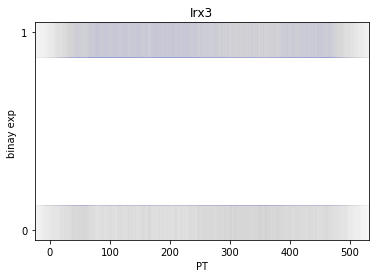

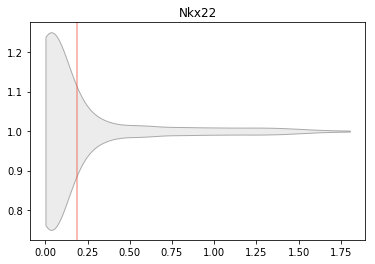

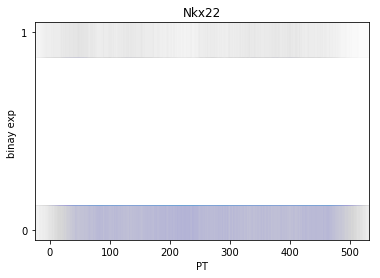

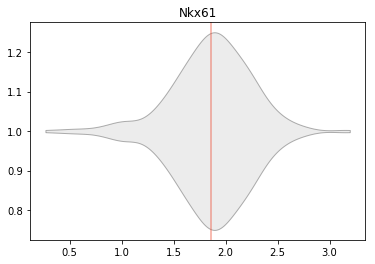

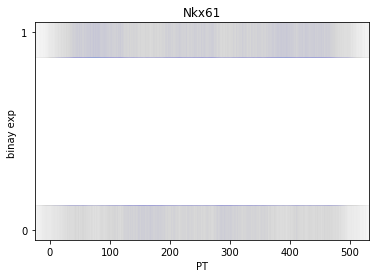

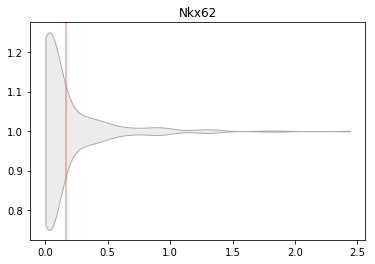

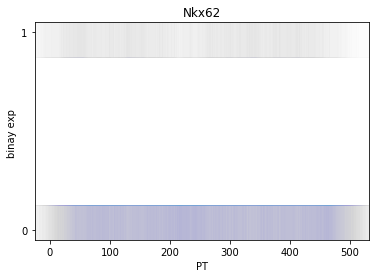

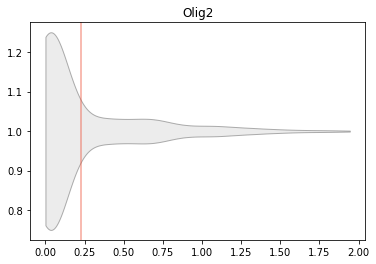

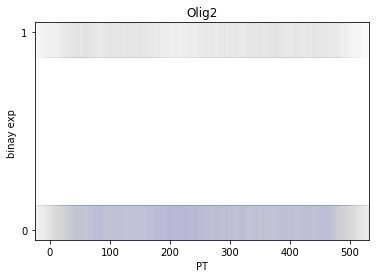

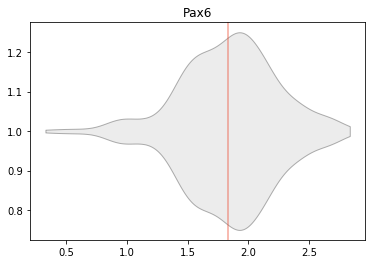

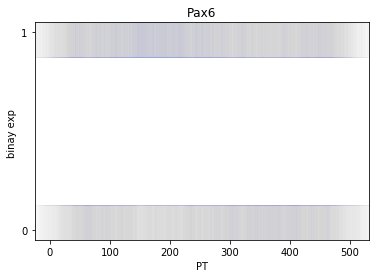

K-mean method threshlding


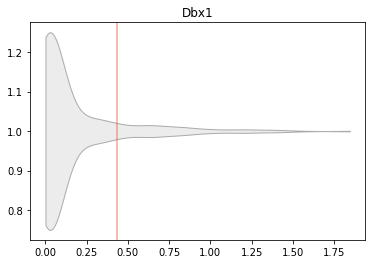

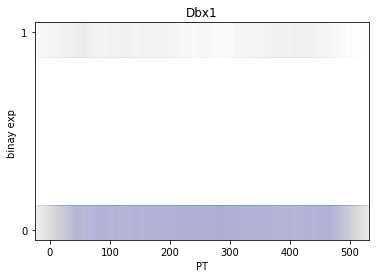

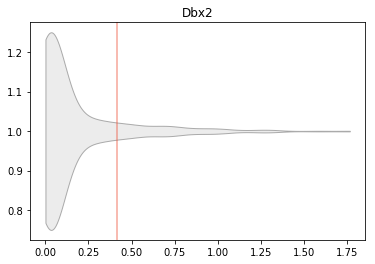

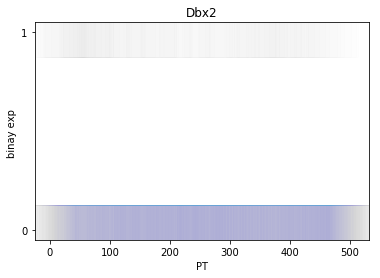

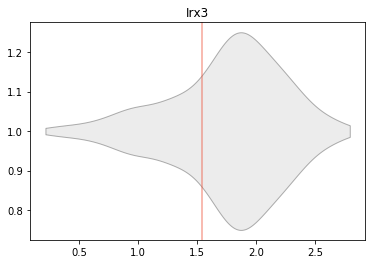

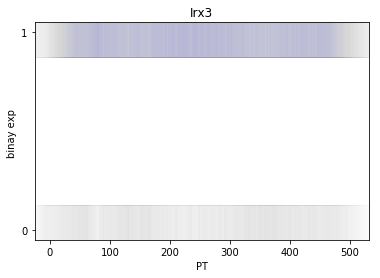

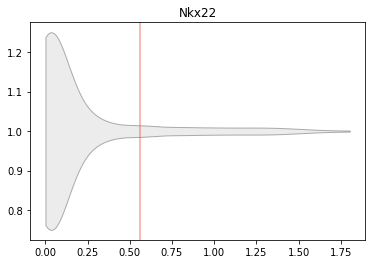

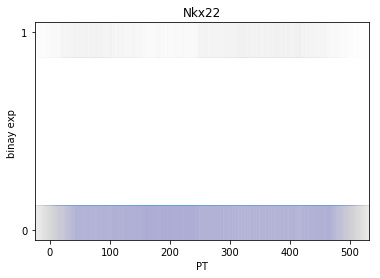

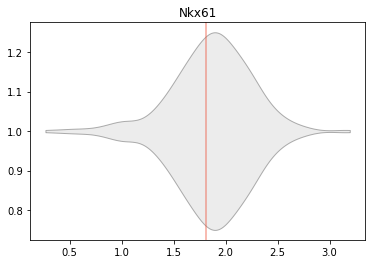

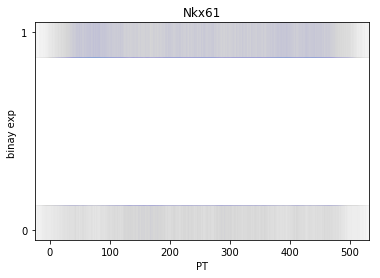

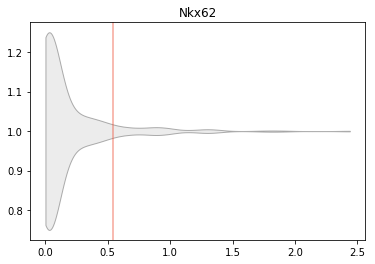

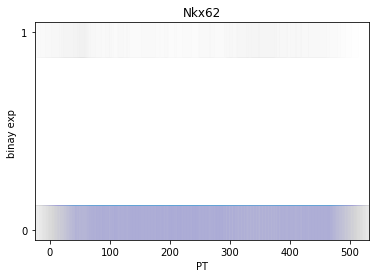

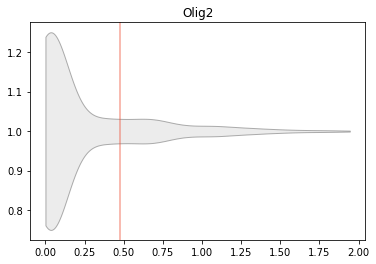

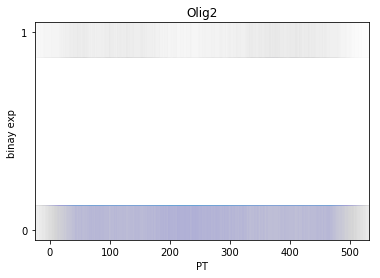

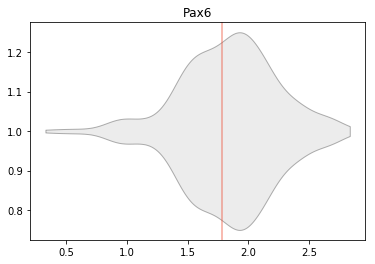

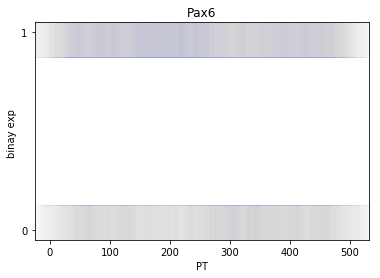

Mean method threshlding


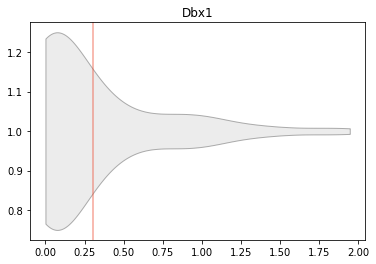

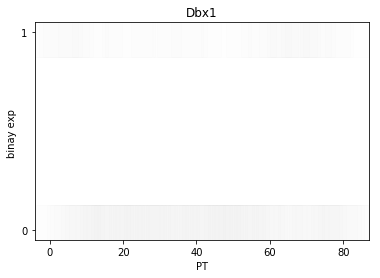

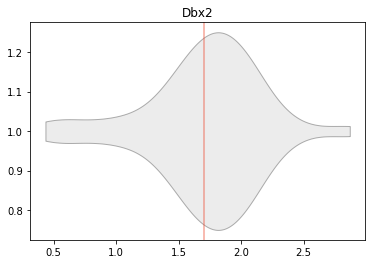

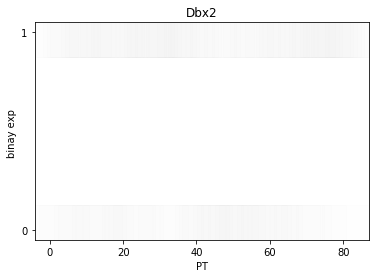

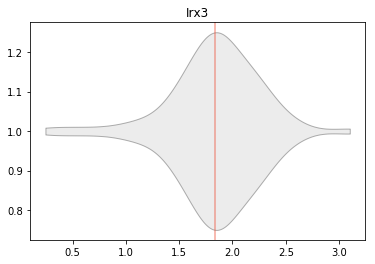

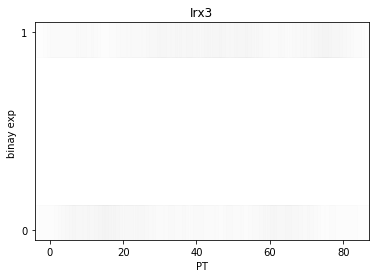

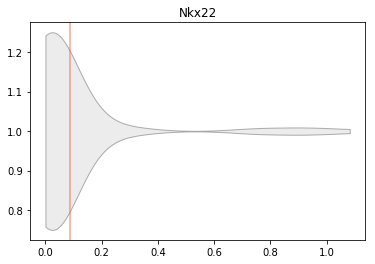

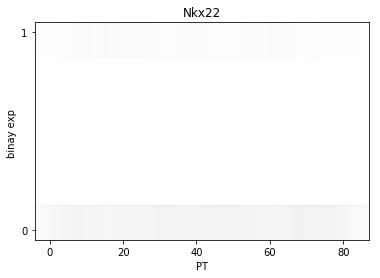

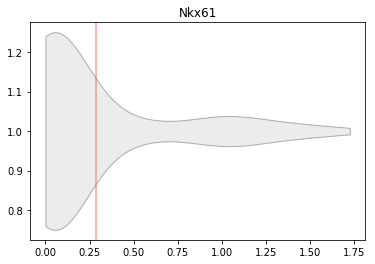

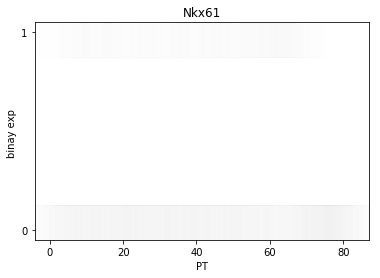

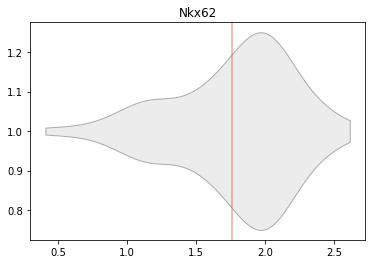

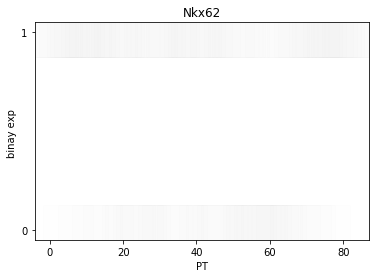

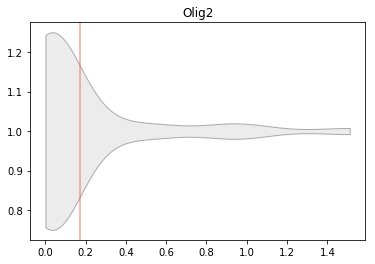

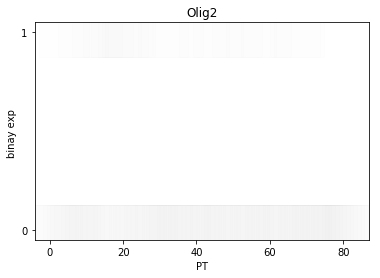

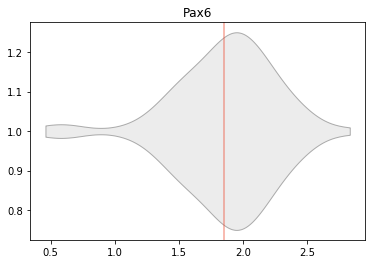

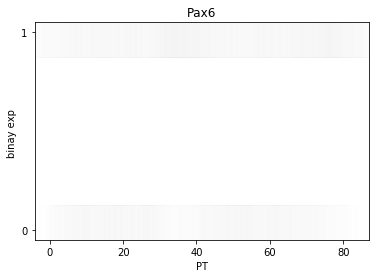

K-mean method threshlding


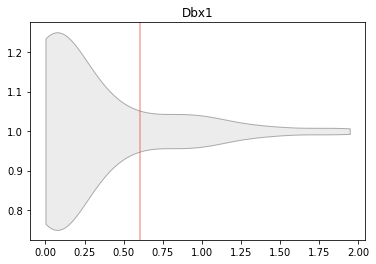

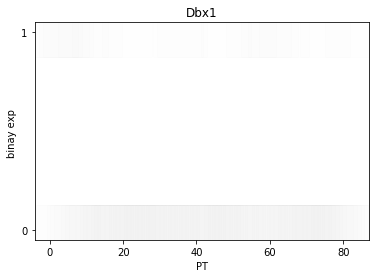

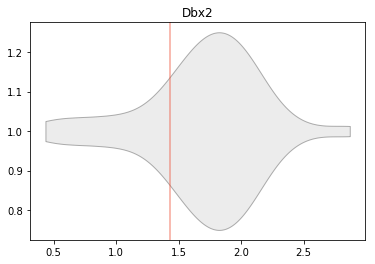

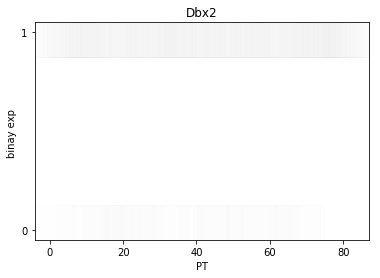

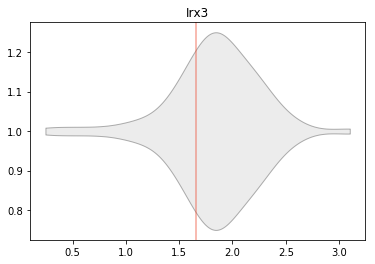

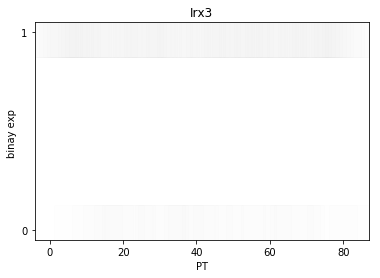

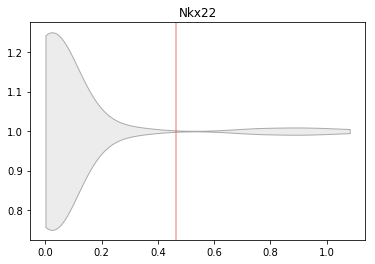

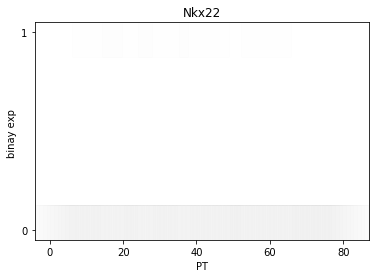

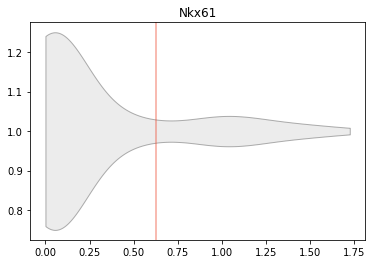

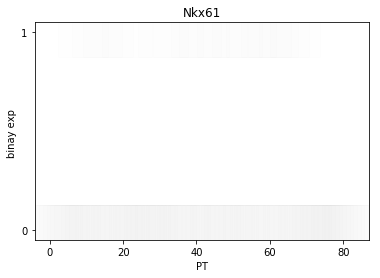

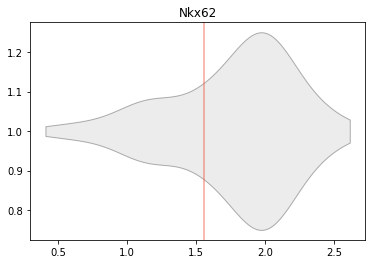

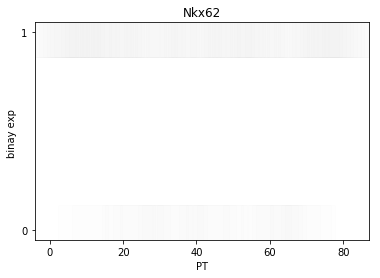

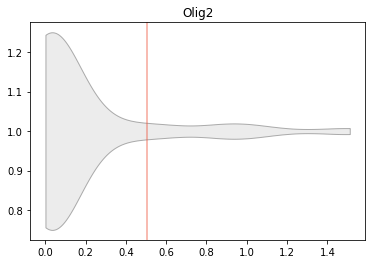

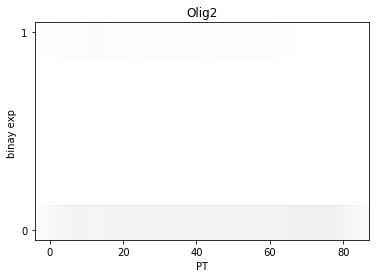

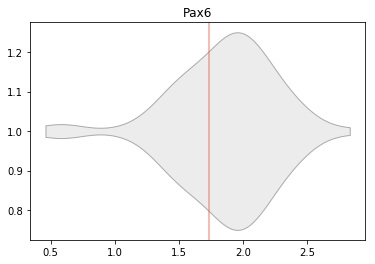

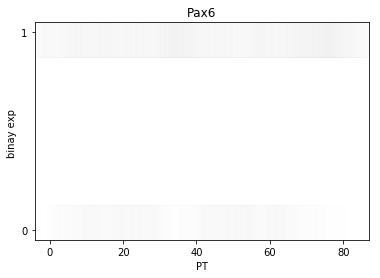

Mean method threshlding


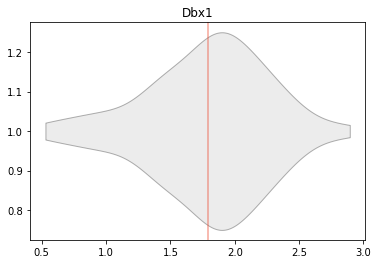

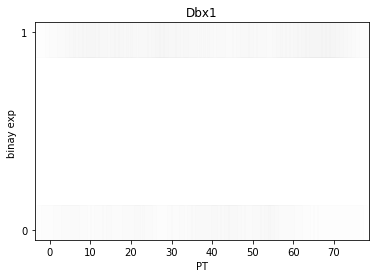

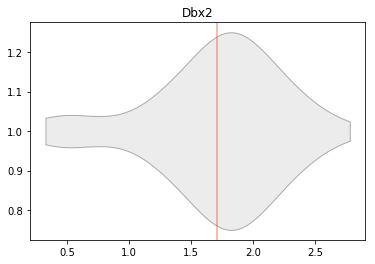

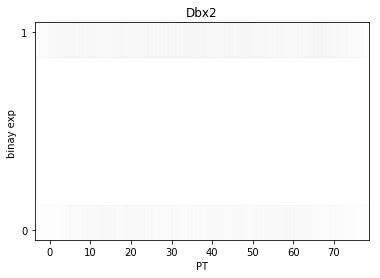

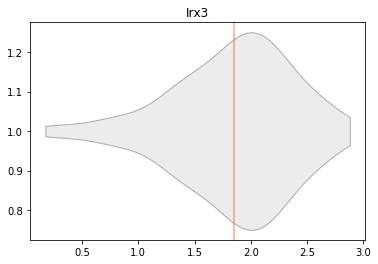

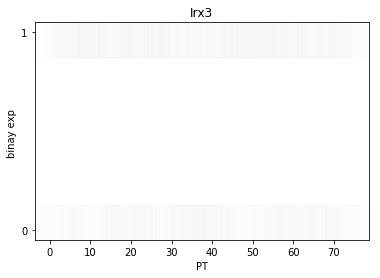

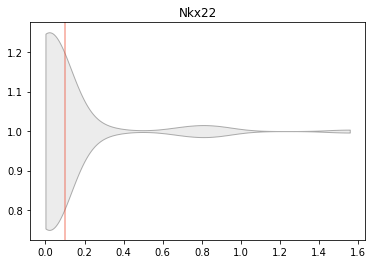

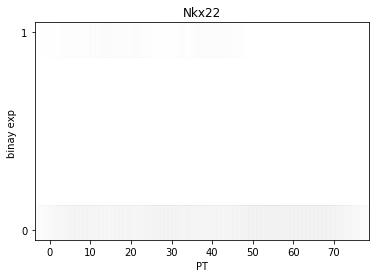

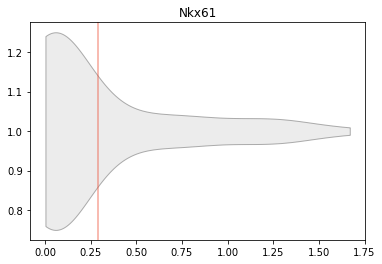

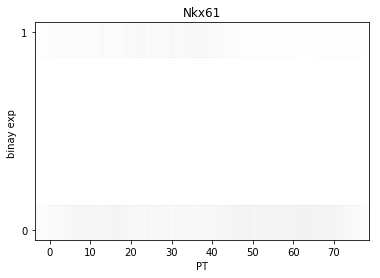

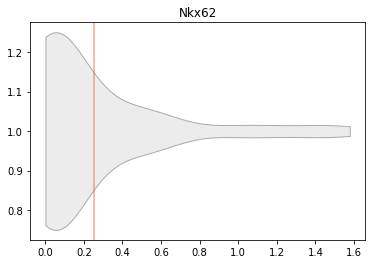

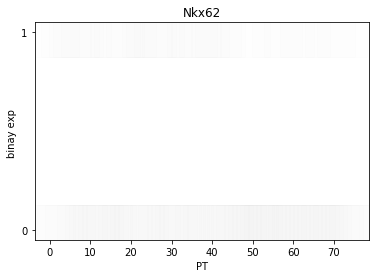

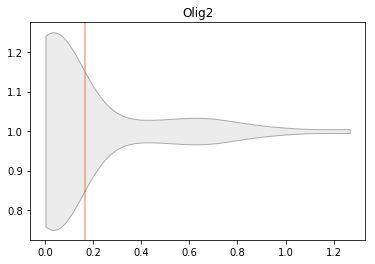

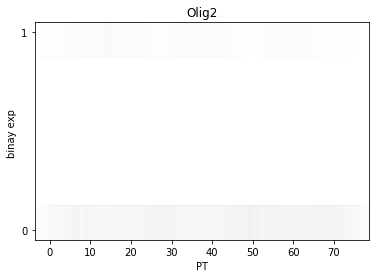

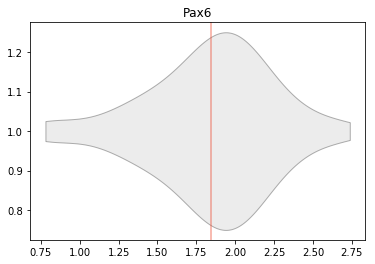

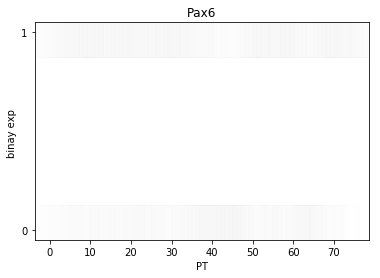

K-mean method threshlding


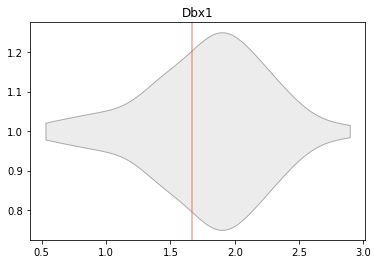

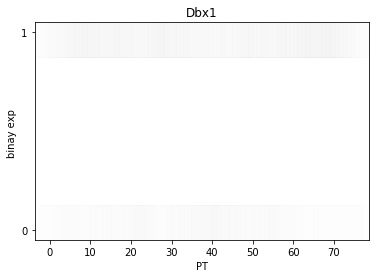

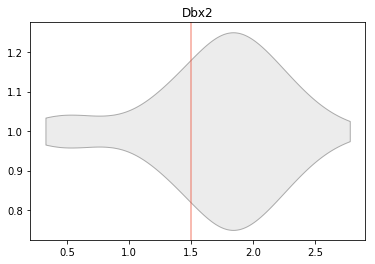

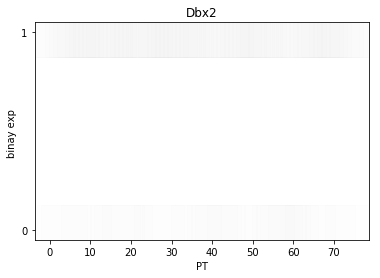

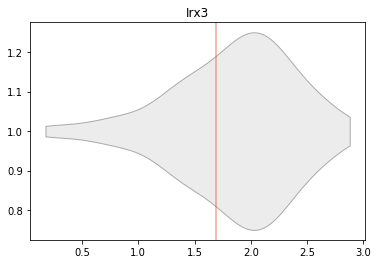

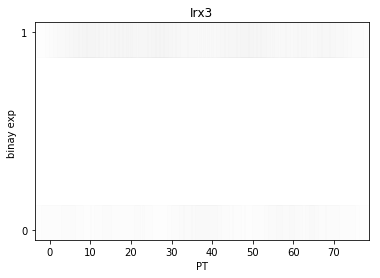

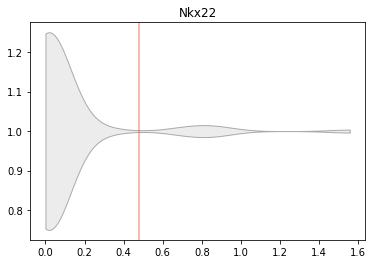

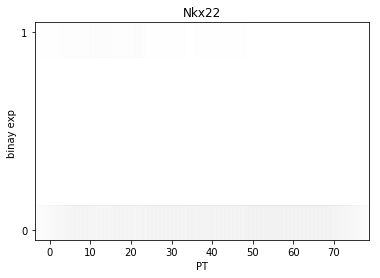

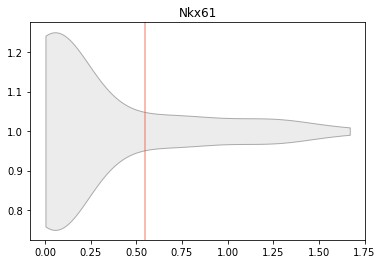

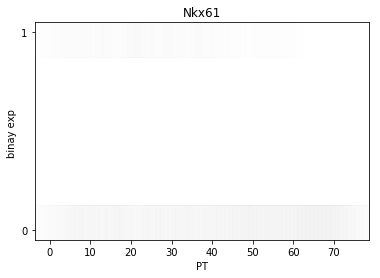

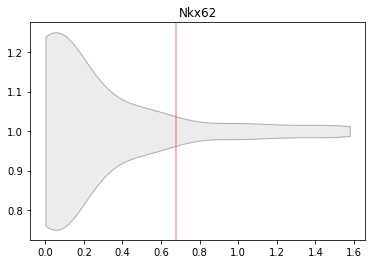

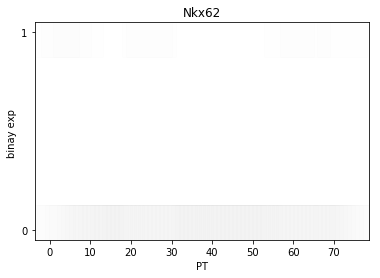

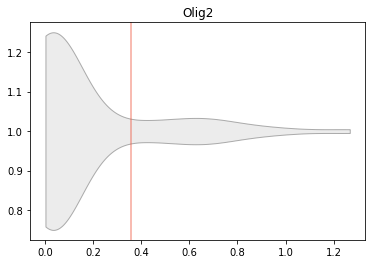

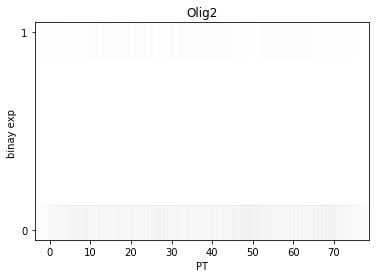

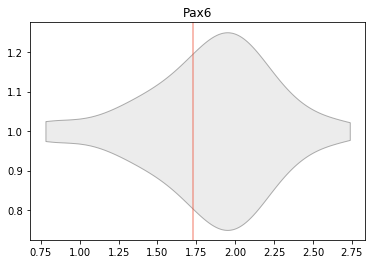

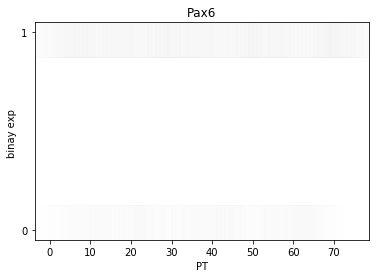

Mean method threshlding


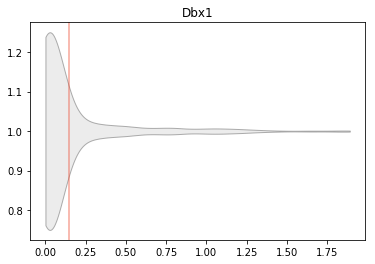

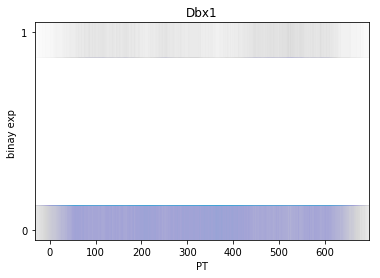

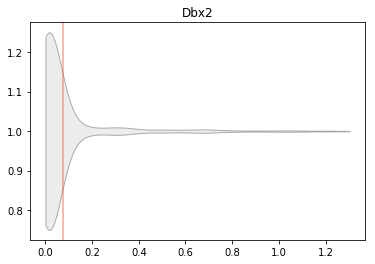

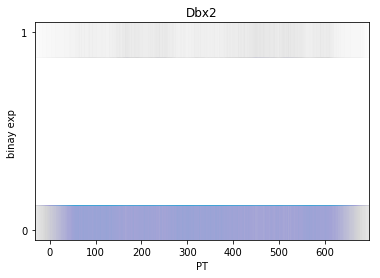

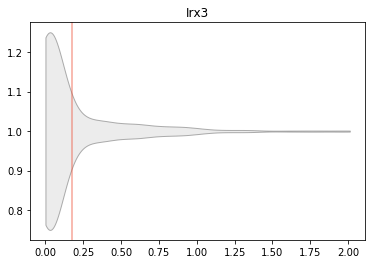

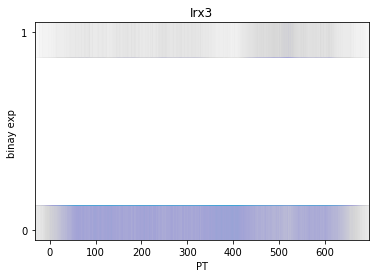

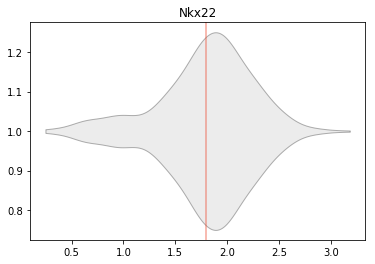

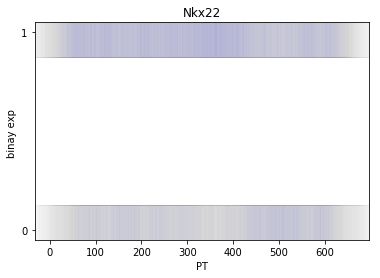

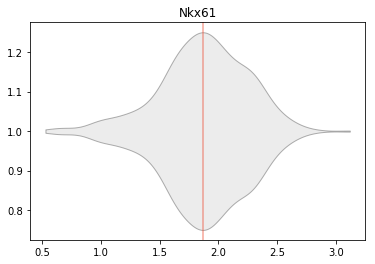

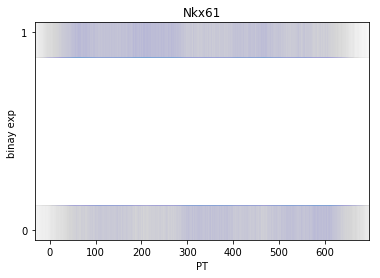

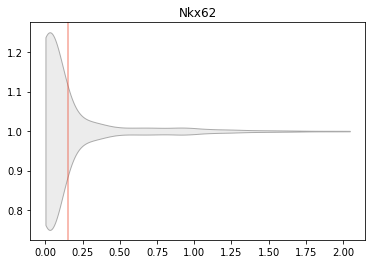

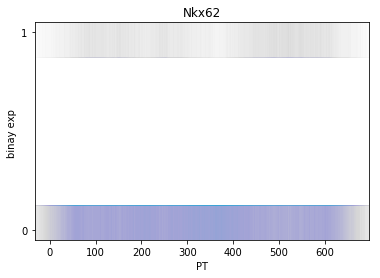

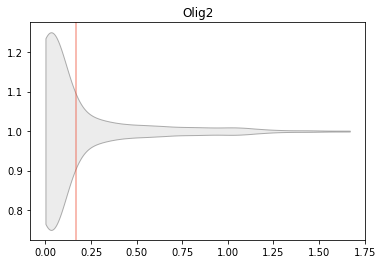

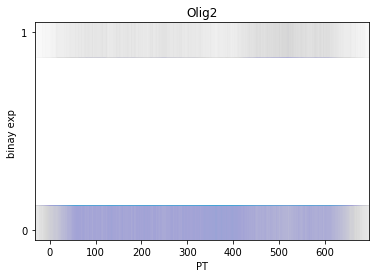

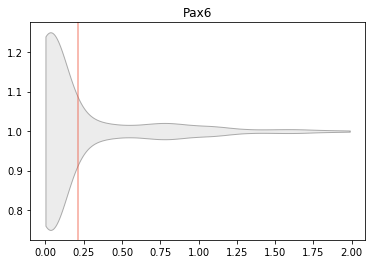

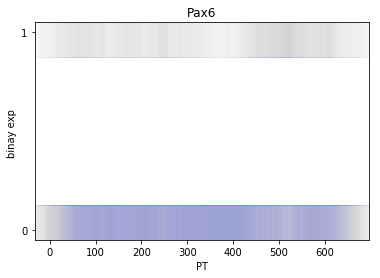

K-mean method threshlding


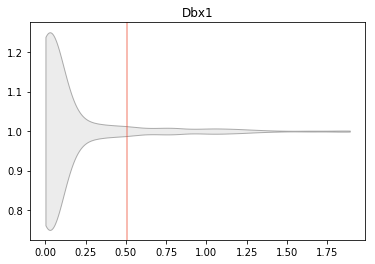

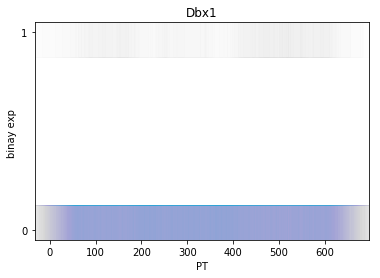

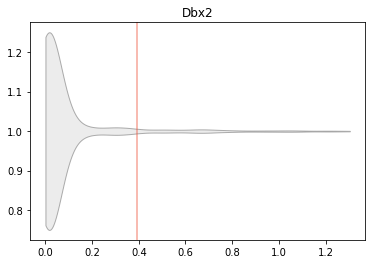

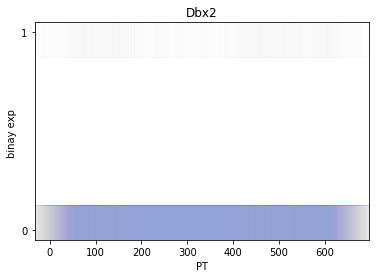

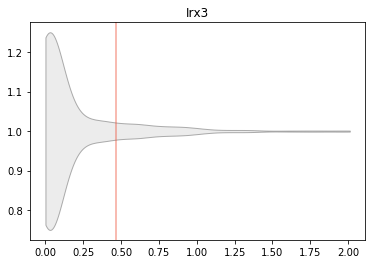

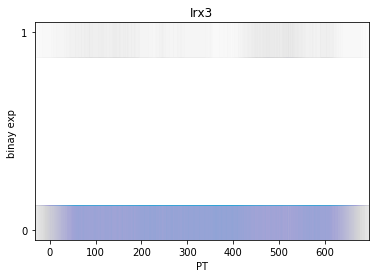

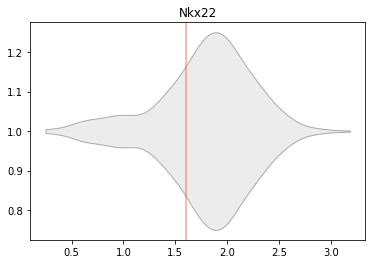

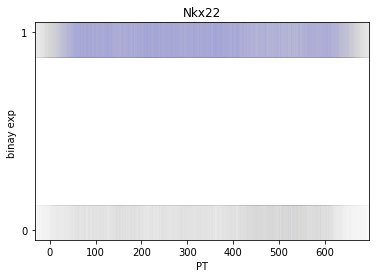

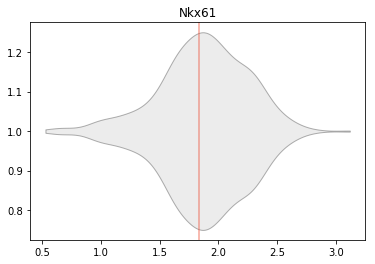

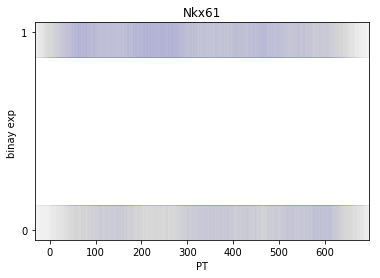

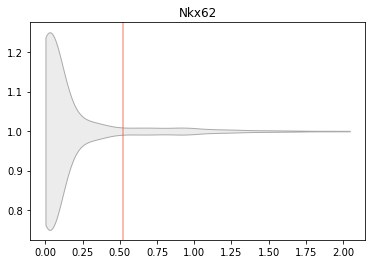

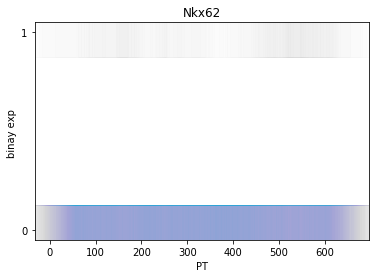

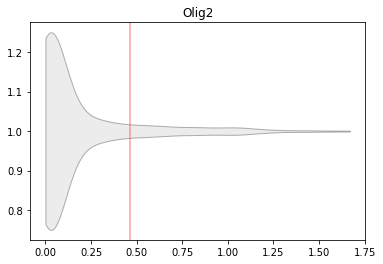

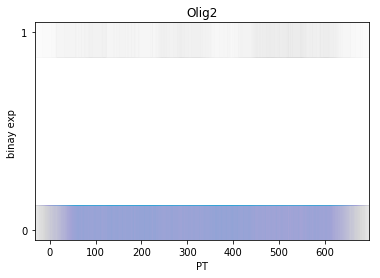

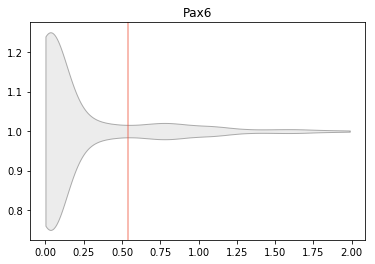

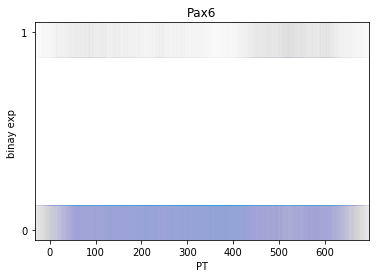

Mean method threshlding


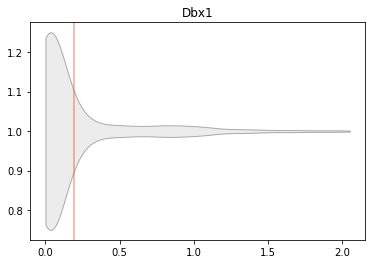

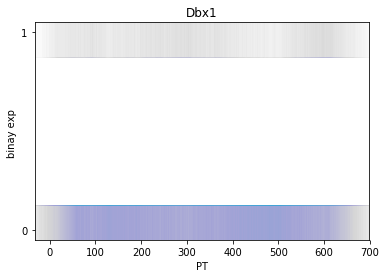

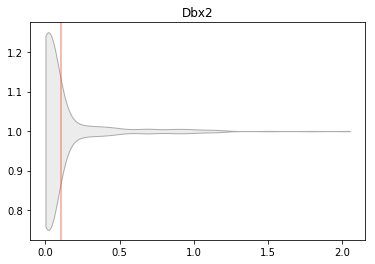

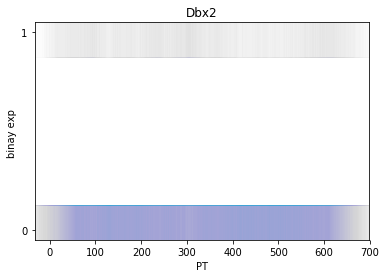

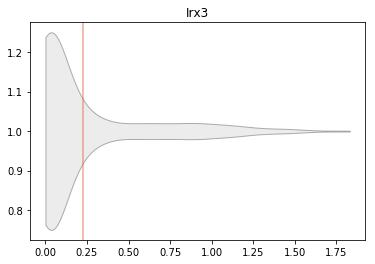

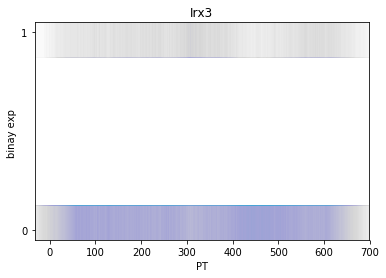

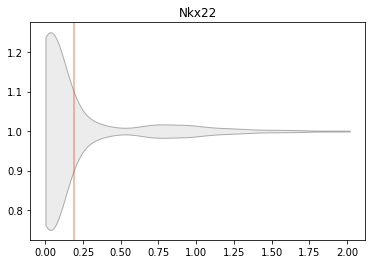

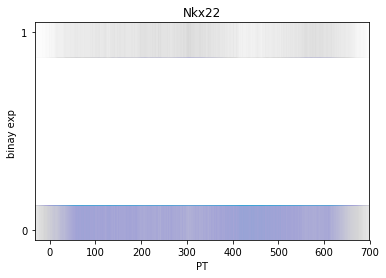

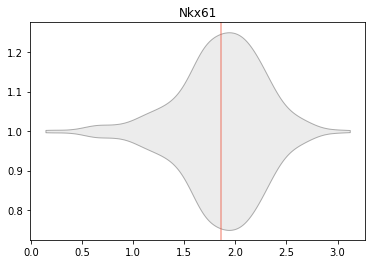

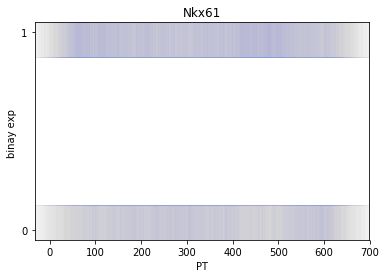

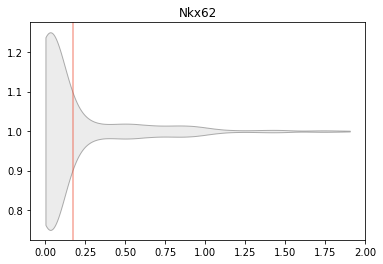

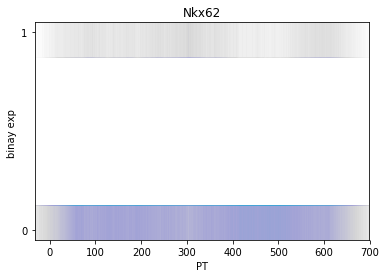

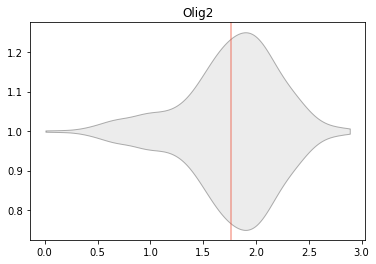

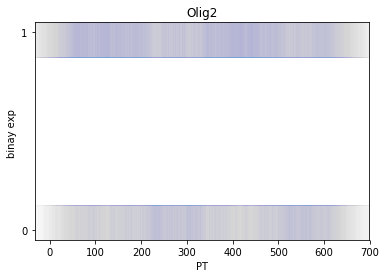

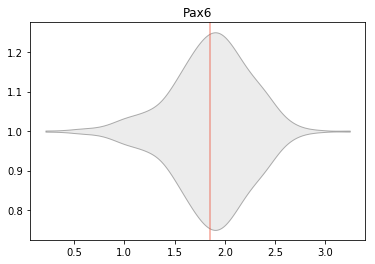

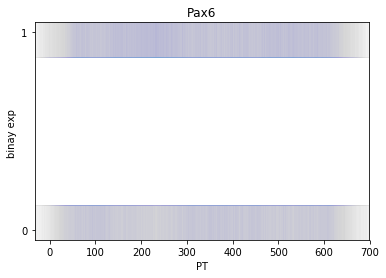

K-mean method threshlding


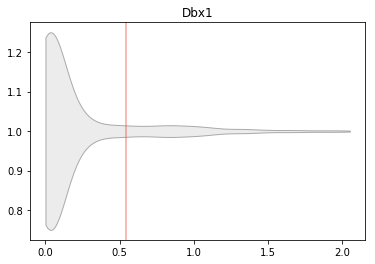

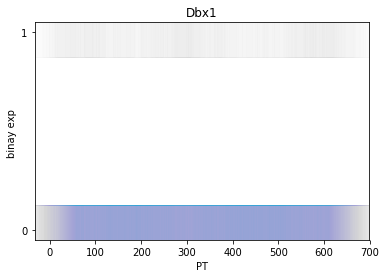

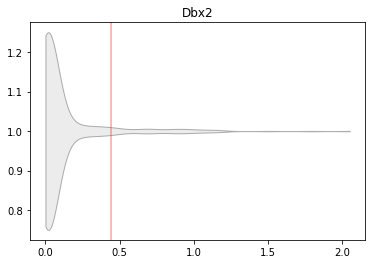

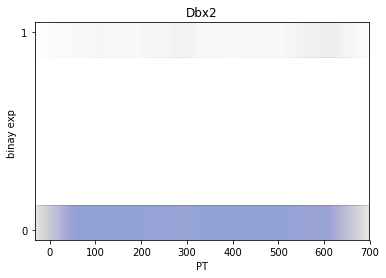

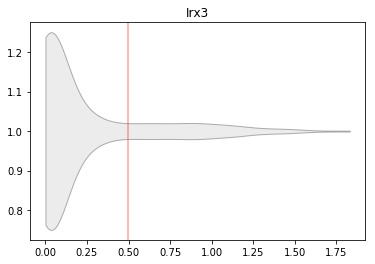

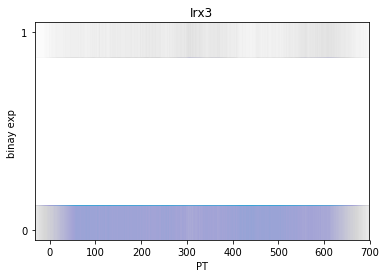

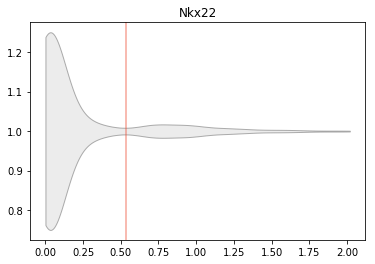

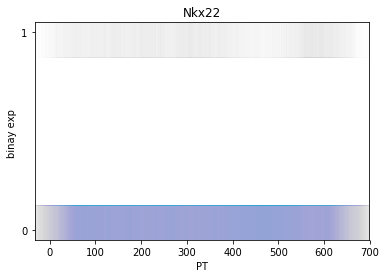

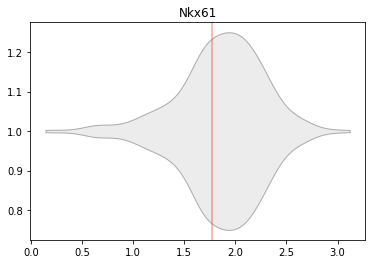

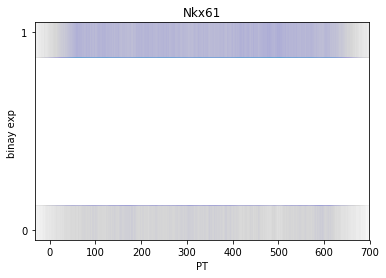

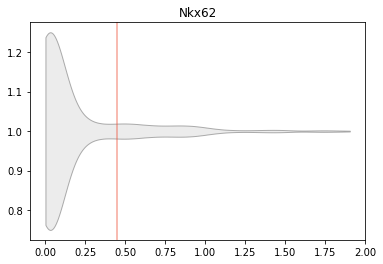

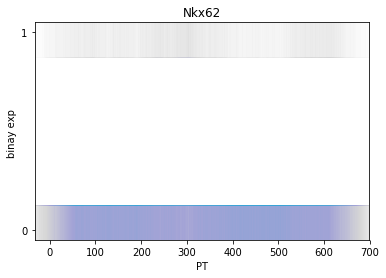

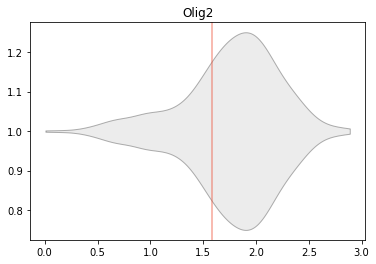

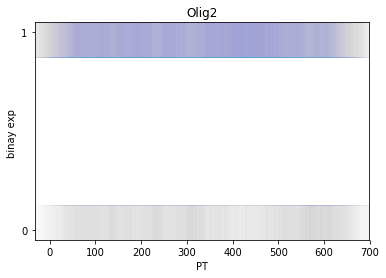

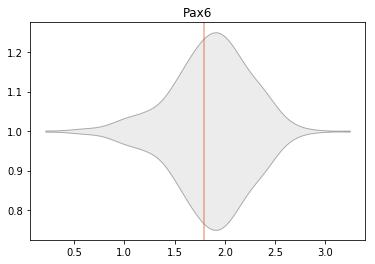

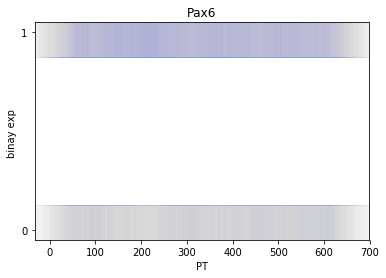

In [9]:
for data_type in data_types: 
    os.chdir(main_path)
    trajectory_list = os.listdir(os.path.join("Beeline_benchmark/run_iQcell", data_type))
    trajectory_list = [x for x in trajectory_list if os.path.isdir(os.path.join("Beeline_benchmark/run_iQcell", data_type, x))]
    for temp_traj in trajectory_list:
        output_path = os.path.join(main_output_path, data_type, temp_traj)
        if os.path.isdir(output_path) == False: 
            os.makedirs(output_path)
        os.chdir(output_path)
        
        input_path = os.path.join(main_input_path, data_type, temp_traj)
        PT_address = os.path.join(input_path, "input_pt.csv")
        expression_add = os.path.join(input_path, 'input_exp.csv')
        Descritized_exoression = os.path.join(input_path, 'Descritized_exoression.csv')
        monocole_all_cells_z3_add = os.path.join(input_path, 'z3_cellorder.txt')
        z3_expression_add=os.path.join(input_path, 'z3_expression.txt')

        
        z3_interaction_add= os.path.join(input_path, 'z3_interaction.txt')
        interaction_add=os.path.join(input_path, 'gene_interactions.txt')

        initial_condition_ = os.path.join(input_path, 'initial_condition.txt')
        GRN_file_address = os.path.join(input_path, 'GRN.txt')
        ABN_GRN_file_address = os.path.join(input_path, 'ABN_GRN.txt')

        nruns_='--runs 50'
        steps_='--steps 20'
        processes_='--processes 1'
        minSustainability_=0.5

        try: 
            number_of_cells_z3=len(pd.read_csv(PT_address))
            include_selfe_activation=False
            Window_size=100 # the window size used in calculating expression density
            Percent_top= 100 # the percent of top interactions to be included !! note only signed one are included
            jump_threshold_method='half'  #'kmeans' or 'mean' or 'median' or half  value
            Threshold_method='Mean' # either 'K-means' or 'Mean'

            size_of_subset= len(pd.read_csv(PT_address)) # size of subset of cells to calculte threshold 
            df_mean, Figs_mean=iqcell.expression_discretization.mean_thresholding_method_and_plot(expression_add,PT_address,
                                                                                                size_of_subset,plot=True)
            df_kmean, Figs_kmean=iqcell.expression_discretization.K_mean_thresholding_method_and_plot(expression_add,PT_address,
                                                                                                size_of_subset,plot=True) 

            iqcell.expression_discretization.export_discretized_expression(Descritized_exoression,df_kmean,df_mean,Threshold_method)

            # 1___generating cell order file:
            monocole_cells_z3=iqcell.gene_hierarchy.generating_cell_order(monocole_all_cells_z3_add,number_of_cells_z3,
                                                                        PT_address)


            # 2_____making the 'z3_expression.txt' file
            expression_data_z3=iqcell.gene_hierarchy.generating_expression_file(Descritized_exoression,z3_expression_add,monocole_cells_z3)

            # 3___calculing the possible gene gene iteractions based on scores and jumps
            jump_thresholds=iqcell.gene_hierarchy.calculate_jump_thresholds_from_data(Window_size,
                                                    expression_data_z3,monocole_cells_z3)

            gene_jumps, genes_avraged_on_window, Figs =iqcell.gene_hierarchy.finding_gene_transition_points (jump_thresholds,
                                                                                                    jump_threshold_method,Window_size,
                                                                                                    expression_data_z3,monocole_cells_z3,
                                                                                                    interaction_add,z3_interaction_add,
                                                                                                    include_selfe_activation,Percent_top)

            gene_order=list(gene_jumps.index)
            number_of_initial_cells=int((len(pd.read_csv(PT_address)))/20)# number of cells with the earliest pt to considered as initial cells

            # only in iqcell v1.1.0,  Initial_gene_states is exported as a dataframe
            Initial_gene_states=iqcell.boolean_simulation.find_and_export_initial_states(number_of_initial_cells,initial_condition_,Descritized_exoression,PT_address)


            # only in iqcell v1.1.0, Check_GRN_for_ABN_simulation exists.
            iqcell.boolean_simulation.Check_GRN_for_ABN_simulation(interaction_add,GRN_file_address,gene_order,Initial_gene_states,ABN_GRN_file_address)

            input_graph_add='in_out/ABNfiles/9.1_output.gml'
            iqcell.boolean_simulation.simulate_Boolean_GRN(ABN_GRN_file_address,initial_condition_,input_graph_add,
                                                        nruns_,steps_,processes_)

            metricsOutput_add='in_out/ABNfiles/9.2_metricsOutput.csv'
            profilesOutput_='in_out/ABNfiles/9.2_profilesOutput.csv'
            node_data_address='in_out/ABNfiles/9.1_output_nodes.csv'

            iqcell.boolean_simulation.read_run_analysis(minSustainability_,input_graph_add,metricsOutput_add,profilesOutput_)
        except Exception as err:
            logging.basicConfig(filename = 'error.log', level=logging.DEBUG)
            logger = logging.getLogger(__name__)
            logger.error(traceback.format_exc())

# copy all the steady states into the unified folder 

In [13]:
os.chdir(main_path)


In [14]:
main_output_path = 'output/Boolean_sim/'
main_input_path = 'output/iQcell_simulations/'

In [15]:
data_types = os.listdir(main_input_path)
data_types = [x for x in data_types if x != '.DS_Store']
#data_types = [x for x in data_types if x != 'dyn-CY']
for temp_data in data_types: 
    traj_list = os.listdir(os.path.join(main_input_path, temp_data))
    ss_df = pd.DataFrame()
    for temp_traj in traj_list: 
        if os.path.isfile(os.path.join(main_input_path, temp_data, temp_traj, "in_out/ABNfiles/9.2_profilesOutput.csv")) == True: 
            temp_ss = pd.read_csv(os.path.join(main_input_path, temp_data, temp_traj, "in_out/ABNfiles/9.2_profilesOutput.csv"), index_col=0)
            temp_ss = temp_ss.T
            ss_df = pd.concat([ss_df, temp_ss], axis = 1)
        else: 
            continue
    if os.path.isdir(os.path.join(main_output_path, temp_data, 'iQcell')) == False: 
        os.makedirs(os.path.join(main_output_path, temp_data, 'iQcell'))
    ss_df.to_csv(os.path.join(main_output_path, temp_data, "iQcell/unique_steady_states_profiles.csv"))